## Synthetic Minority Oversampling TEchnique (SMOTE) to balance the training data-set
## This notebook is to apply SMOTE on Scania Dataset with PCA (PCs=11), with different Imbalance Ratio

**Yasmin Fathy <Fathy.Yasmin@gmail.com>**

**Latest Updates: 30/08/2020**

In [1]:
import pandas as pd
import numpy as np
import os
from pprint import pprint

# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.set_option('display.max_colwidth', -1)

#Setup to show all results in jupiter not only the last one:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
from pprint import pprint

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (20,20)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

## Evaluation

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, make_scorer,\
    recall_score, f1_score, precision_recall_curve, log_loss, cohen_kappa_score,roc_curve, auc
from tqdm import tqdm

In [3]:
RANDOM_STATE = 42

**APS Misclasification Cost Function**

In [4]:
def __perform_measure(y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        y_actual = list(y_actual)
        y_hat = list(y_hat)
        for i in range(len(y_hat)):
            if y_actual[i] == y_hat[i] == 1:
                TP += 1
            if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
                FP += 1
            if y_actual[i] == y_hat[i] == 0:
                TN += 1
            if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
                FN += 1

        return [TP, FP, TN, FN]

def custom_cost_fn_loss(y_actual, y_hat):
        [TP, FP, TN, FN] = __perform_measure(y_actual, y_hat)
        # print(len(list(y_actual)),
        #       len(list(y_hat)))
        # cm = confusion_matrix(list(y_actual), list(y_hat))
        # print(len(cm))
        # print(len(cm[0]))
        # print(cm)
        # FP = cm[0][1]
        # FN = cm[1][0]
        return (500 * FN) + (FP * 10)
    
APS_cost_fn = make_scorer(custom_cost_fn_loss, greater_is_better=False)

### ML Model Evalution

- **y** : original label in the testing-set
- **y_predict**: predicted label from the ML algorithm
- **y_predict_prob**: probability output of the algorithm about the minority class

**Plotting the precision, recall curve**

In [5]:
def plot_precession_recall_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='Precision Recall curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Precision Recall curve  '+ str(alg_name))
    plt.legend(loc="lower right")
    plt.show();

In [6]:
def plot_roc_auc_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

**Evaluating the results using a set of metrics**

In [7]:
def model_evaluaiton(y, y_predict, alg_name):        
            print(classification_report(y, list(y_predict)))
            cm = confusion_matrix(y, list(y_predict))
            print(cm)
            print("Accuracy:", accuracy_score(y, y_predict))
            print("roc_auc_score:", roc_auc_score(y, y_predict))
            print("precision_score:", precision_score(y, y_predict))
            print("recall_score:", recall_score(y, y_predict))
            print("f1_score:", f1_score(y, y_predict))
            FP = cm[0][1]
            FN = cm[1][0]
            print("CM: FP", FP)
            print("CM: FN", FN)
            print("APS Cost = ", (500 * FN) + (FP * 10))
            plot_precession_recall_curve(y, y_predict, alg_name)
            plot_roc_auc_curve(y, y_predict, alg_name)

**Finding the threshold that minimises the misclassification of the minority class i.e. class = 1 and apply the best threshold as post-processing steps**

In [8]:
def find_cut_off(y, y_predict_prob_maj):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict_prob_maj)
    min_cost = np.inf
    best_threshold = 0.5
    costs = []
    for threshold in tqdm(thresholds):
        #y_pred_threshold = np.where(scores > threshold, 0, 1)
        y_pred_threshold = y_predict_prob_maj > threshold
        tn, fp, fn, tp = confusion_matrix(y, y_pred_threshold).ravel()
        cost = 10*fp + 500*fn
        costs.append(cost)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    print("Best threshold: {:.4f}".format(best_threshold))
    print("Min cost: {:.2f}".format(min_cost))
    return best_threshold
    

---

## Read training and testing files

In [9]:
data_dir ="ScaniaDataset/dimReduction/"
df_train = pd.read_csv(data_dir+"pca_aps_mean_failure_train_set.csv")
df_test =  pd.read_csv(data_dir+"pca_aps_mean_failure_test_set.csv")

# data_dir ="ScaniaDataset/imputation/"
# df_train = pd.read_csv(data_dir+"imp_aps_mean_failure_training_set.csv")
# df_test =  pd.read_csv(data_dir+"imp_aps_mean_failure_test_set.csv")

In [10]:
df_train["class"].value_counts()

df_test["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

0    15625
1      375
Name: class, dtype: int64

In [11]:
df_train.head()
df_test.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,-0.357653,0.149168,0.785559,0.107379,-0.068720,-0.028512,0.128307,0.002902,-0.073669,0.079233,-0.019663,0
1,-0.009868,0.178451,-0.153641,-0.106095,0.115751,0.677376,0.038713,0.021226,0.052543,-0.016909,-0.012898,0
2,0.036263,-0.202770,-0.164386,-0.072079,0.131766,-0.043973,-0.051563,-0.000143,0.000497,-0.034116,-0.000904,0
3,0.207965,-0.419020,-0.145090,-0.048601,-0.000098,-0.007554,-0.008067,0.004260,0.006622,0.011792,-0.001259,0
4,-0.111736,0.259781,-0.174570,-0.061653,-0.000418,-0.020208,0.079826,-0.010607,0.004089,-0.047178,-0.014056,0


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,0.161155,-0.296518,-0.147703,-0.064035,-0.017811,-0.017302,0.001606,0.008635,0.022569,0.004805,-0.000669,0
1,0.197147,-0.390714,-0.145632,-0.052749,-0.003007,-0.008112,-0.006774,0.005026,0.008747,0.010879,-0.000986,0
2,-0.271152,0.611412,-0.183003,-0.143001,-0.002290,-0.010953,0.107131,-0.045472,0.038387,-0.092350,0.044199,0
3,-0.134755,0.120177,-0.180050,-0.094396,0.112898,-0.045628,0.058169,0.005929,0.011544,-0.038997,-0.004686,0
4,0.171726,-0.324381,-0.146679,-0.064361,-0.004982,-0.002021,-0.007429,0.004521,0.007393,0.011175,-0.000230,0


----

### Generate data by SMOTE to preserve different ratio between the majoirty and minority classes

In [12]:
from collections import Counter
from numpy import log
from imblearn.over_sampling import SMOTE 

Using TensorFlow backend.


**Using the Shannon entropy as a measure of balance**
- Where IR tends to be:
    - 0 when the data is highly imbalanced and 
    - 1 when the data is balanced.

- Inspired from: 
https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance


In [211]:
def imbalance_ratio(seq):
    n = len(seq)
    classes = [(label,float(count)) for 
               label,count in Counter(seq).items()]
    #print(classes)
    k = len(classes)
    #print(k)
    #calculate shannon entropy
    H = -sum([ (count/n) * log((count/n)) 
              for label,count in classes]) 
    #print(H)
    # get imbalance ratio
    IR = H/log(k)
    print("Non-normliased = ", str(H))
    print("IR = ", str(IR))
    return IR # near 0: high imbalance, near 1: high balance

**Check if we have the same value report for Normalised Shannon Entropy that is calculated in paper "A methodology..." isn't normalised**
- It turns out the shannon value in their paper isn't normalised, check the example on the original data
- Original data has the following counts for each class
[(0, 59000.0), (1, 1000.0)]

In [221]:
log((1/60)) 

-4.0943445622221

In [217]:
#[(0, 59000.0), (1, 1000.0)]
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))/log(2)

0.08476607571480994

0.1222915970693747

**Measure IR for the original data**

In [212]:
imbalance_ratio(df_train["class"])

[(0, 59000.0), (1, 1000.0)]
2
0.08476607571480994
Non-normliased =  0.08476607571480994
IR =  0.1222915970693747


0.1222915970693747

**Get the minority class samples**

In [15]:
def get_minority(df_train):
    return df_train[df_train['class'] == 1]

**Define smote function**

In [16]:
def generate_smote(df, k = 5, sampling_strategy = 5/59):
    sm = SMOTE(random_state=RANDOM_STATE, 
               k_neighbors=k, n_jobs=-1, 
               sampling_strategy=sampling_strategy)
    df = df.apply(pd.to_numeric)
    y_train = df['class']
    X_train = df.drop(['class'], axis=1)
    
    y_train_0 = sum(y_train==0)
    y_train_1 = sum(y_train==1)
    print("Before OverSampling, counts of label '1': {} ({}%)".format(y_train_1, y_train_1/len(y_train) * 100))
    print("Before OverSampling, counts of label '0': {} ({}%)\n".format(y_train_0, y_train_0/len(y_train) * 100))
    
    # Apply smote
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    
    y_train_res_0 = sum(y_train_res == 0)
    y_train_res_1 = sum(y_train_res == 1)
    
    print("After OverSampling, counts of label '1': {} ({}%)".format(y_train_res_1, y_train_res_1/len(y_train_res)* 100))
    print("After OverSampling, counts of label '0': {} ({}%)".format(y_train_res_0, y_train_res_0/len(y_train_res)* 100))
    
    df_ = pd.DataFrame(X_train_res, columns=X_train.columns)
    df_["class"] = y_train_res
    return df_

**To reproduce Case II Experiements:**
- sampling_strategy = 2/59 => IR = 0.2
- sampling_strategy = 5/59 => IR = 0.4
- sampling_strategy = 9/59, 10/59, 11/59 => IR = 0.6
- sampling_strategy = 18/59 => IR = 0.8
- sampling_strategy = 59/59 => IR = 1.0

**define a dataframe for each case**

In [17]:
#sample_strategies = [2, 5, 10, 18, 59]

In [18]:
x=imbalance_ratio(df_train['class'])

print("".join(["="]*20))
## create df for IR = 0.2
df_train_2 = generate_smote(df_train, sampling_strategy = 2/59)
x=imbalance_ratio(df_train_2['class'])
print("".join(["="]*20))

## create df for IR = 0.4
df_train_5 = generate_smote(df_train, sampling_strategy = 5/59)
x=imbalance_ratio(df_train_5['class'])
print("".join(["="]*20))

## create df for IR = 0.6
df_train_10 = generate_smote(df_train, sampling_strategy = 10/59)
x=imbalance_ratio(df_train_10['class'])
print("".join(["="]*20))

## create df for IR = 0.8
df_train_18 = generate_smote(df_train, sampling_strategy = 18/59)
x=imbalance_ratio(df_train_18['class'])
print("".join(["="]*20))

## create df for IR = 1.0
df_train_59 = generate_smote(df_train, sampling_strategy = 1.0)
x=imbalance_ratio(df_train_59['class'])

IR =  0.1222915970693747
Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 2000 (3.278688524590164%)
After OverSampling, counts of label '0': 59000 (96.72131147540983%)
IR =  0.20818094555717104
Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 5000 (7.8125%)
After OverSampling, counts of label '0': 59000 (92.1875%)
IR =  0.3955378064564774
Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 10000 (14.492753623188406%)
After OverSampling, counts of label '0': 59000 (85.5072463768116%)
IR =  0.596999516760455
Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts o

## Get difference between generated and original
**Note: SMOTE concatenates the newly generated samples to the end of the original input data and returns that as the output**
- ref: https://datascience.stackexchange.com/questions/12768/location-of-the-resampled-data-from-smote

In [89]:
# get minority of the original data
df_minority = get_minority(df_train)
len(df_minority)

1000

In [87]:
# df_minroty: is the data samples of the minority class in the original data
# df_generated: is all data samples including synthetic generated minority class and original data samples
def get_ks_test(df_minroty, df_generated, return_generated_df = False):
    # get the generated samples from smote by getting the difference between original dataset in "df_train" and sampled dataset "df_generated"
    # (which contains/combines original and generated data)
    minority_generated = df_generated[~df_generated.apply(tuple,1).isin(df_train.apply(tuple,1))]
    no_cols = len(df_minroty.columns)-1
    for idx in range(0, no_cols):
        print(stats.ks_2samp(df_minroty.iloc[:,idx], 
                       minority_generated.iloc[:, idx]))
    if return_generated_df:
        return minority_generated
    

In [222]:
# minority_generated = df_train_5[~df_train_5.apply(tuple,1).isin(df_train.apply(tuple,1))]
# minority_generated = minority_generated.drop(['class'], axis=1)
# # minority_generated

# minority_original = df_minority.drop(['class'], axis=1)
# # minority_original

# minority_original.corrwith(minority_generated, axis=0)

In [118]:
# from scipy.stats import pearsonr
# corr, _ = pearsonr(minority_original, minority_generated)
# corr
# p = minority_generated.to_numpy()
# q = minority_original.to_numpy()

# BC=np.sum(np.sqrt(p*q))
# BC

In [98]:
get_ks_test(df_minority, df_train_2)

Ks_2sampResult(statistic=0.041, pvalue=0.37012017606173)
Ks_2sampResult(statistic=0.025, pvalue=0.9136894237272155)
Ks_2sampResult(statistic=0.032, pvalue=0.6854967337920594)
Ks_2sampResult(statistic=0.043, pvalue=0.3136800387320582)
Ks_2sampResult(statistic=0.038, pvalue=0.4659595288557257)
Ks_2sampResult(statistic=0.052, pvalue=0.13385273551786803)
Ks_2sampResult(statistic=0.057, pvalue=0.07761108123267829)
Ks_2sampResult(statistic=0.039, pvalue=0.43260886958153144)
Ks_2sampResult(statistic=0.032, pvalue=0.6854967337920594)
Ks_2sampResult(statistic=0.023, pvalue=0.9542189106778983)
Ks_2sampResult(statistic=0.025, pvalue=0.9136894237272155)


In [95]:
get_ks_test(df_minority, df_train_5)

Ks_2sampResult(statistic=0.025, pvalue=0.6993741991310154)
Ks_2sampResult(statistic=0.02125, pvalue=0.8629016839424745)
Ks_2sampResult(statistic=0.031, pvalue=0.425529165568137)
Ks_2sampResult(statistic=0.0195, pvalue=0.921258416347441)
Ks_2sampResult(statistic=0.0275, pvalue=0.5806177304235198)
Ks_2sampResult(statistic=0.02725, pvalue=0.5923831558631667)
Ks_2sampResult(statistic=0.047, pvalue=0.05835106571971508)
Ks_2sampResult(statistic=0.016, pvalue=0.9865950232449803)
Ks_2sampResult(statistic=0.02975, pvalue=0.47838846344073405)
Ks_2sampResult(statistic=0.038, pvalue=0.1982492670813468)
Ks_2sampResult(statistic=0.0225, pvalue=0.8127482964130435)


In [94]:
get_ks_test(df_minority, df_train_10)

Ks_2sampResult(statistic=0.027555555555555555, pvalue=1.0)
Ks_2sampResult(statistic=0.029555555555555557, pvalue=1.0)
Ks_2sampResult(statistic=0.030444444444444444, pvalue=1.0)
Ks_2sampResult(statistic=0.016444444444444446, pvalue=1.0)
Ks_2sampResult(statistic=0.021111111111111112, pvalue=1.0)
Ks_2sampResult(statistic=0.019222222222222224, pvalue=1.0)
Ks_2sampResult(statistic=0.049777777777777775, pvalue=1.0)
Ks_2sampResult(statistic=0.019333333333333334, pvalue=1.0)
Ks_2sampResult(statistic=0.023666666666666666, pvalue=1.0)
Ks_2sampResult(statistic=0.036444444444444446, pvalue=1.0)
Ks_2sampResult(statistic=0.02411111111111111, pvalue=1.0)


In [93]:
get_ks_test(df_minority, df_train_18)

Ks_2sampResult(statistic=0.026411764705882357, pvalue=0.5252589377957921)
Ks_2sampResult(statistic=0.0245294117647058, pvalue=0.6207174084777936)
Ks_2sampResult(statistic=0.03258823529411764, pvalue=0.26839990232238914)
Ks_2sampResult(statistic=0.017235294117647015, pvalue=0.9417472281799789)
Ks_2sampResult(statistic=0.01917647058823524, pvalue=0.878090583862002)
Ks_2sampResult(statistic=0.02047058823529413, pvalue=0.8235735827051673)
Ks_2sampResult(statistic=0.043823529411764706, pvalue=0.05315803677282936)
Ks_2sampResult(statistic=0.017470588235294127, pvalue=0.9353567952889995)
Ks_2sampResult(statistic=0.018529411764705905, pvalue=0.9019789788192352)
Ks_2sampResult(statistic=0.032294117647058806, pvalue=0.2781735153976471)
Ks_2sampResult(statistic=0.02158823529411763, pvalue=0.7709002914958005)


In [91]:
get_ks_test(df_minority, df_train_59)

Ks_2sampResult(statistic=0.026551724137931054, pvalue=0.49229094233774373)
Ks_2sampResult(statistic=0.025275862068965482, pvalue=0.556407834187072)
Ks_2sampResult(statistic=0.030120689655172395, pvalue=0.3344181822588508)
Ks_2sampResult(statistic=0.016844827586206867, pvalue=0.943046163084221)
Ks_2sampResult(statistic=0.018258620689655183, pvalue=0.8984995414802299)
Ks_2sampResult(statistic=0.025034482758620635, pvalue=0.5688576391530995)
Ks_2sampResult(statistic=0.04150000000000009, pvalue=0.06767691037715336)
Ks_2sampResult(statistic=0.015965517241379318, pvalue=0.9635749331330168)
Ks_2sampResult(statistic=0.016965517241379346, pvalue=0.9397920446889398)
Ks_2sampResult(statistic=0.028551724137931028, pvalue=0.3993914566395138)
Ks_2sampResult(statistic=0.018482758620689654, pvalue=0.8902055584328822)


In [92]:
# df_2_generated = df_train_2[~df_train_2.apply(tuple,1).isin(df_train.apply(tuple,1))]
# len(df_2_generated)

**Prepare test dataset**

In [19]:
y_test = df_test['class']
X_test = df_test.drop(['class'], axis=1)

In [20]:
len(X_test)

16000

----

## ML Predictive models on the data with augmentation minotity samples generated from SMOTE
**LR, RF, XGBoost are trained and tested for each case mentioned above**

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [22]:
#scoring_fn = "f1_weighted"
scoring_fn = APS_cost_fn

**Prepare training dataset**

In [23]:
def get_train_data(df_t):
    y_train = df_t['class']
    X_train = df_t.drop(['class'], axis=1)
    return X_train, y_train
    

**Make prediction of best model given X_test**

In [24]:
def model_prediction(best_model, X_test):
    print("Best estimator: ", best_model.best_estimator_)
    # X = X.values.reshape(-1, 1)
    model_prediction = best_model.predict(X_test)
    model_prob_prediction = best_model.predict_proba(X_test) 
    return model_prediction, model_prob_prediction

### Logistic Regression: 

In [25]:
# y_train = df_train['class']
# X_train = df_train.drop(['class'], axis=1)

In [26]:
def lr_model(X_train, y_train):
    # LR_hyperparameters = dict(C=[0.01, 1, 10, 100],
    #                          max_iter=[6000])  # hyperparameter options

    # # Best options obtained from running the params mentioned above
    LR_hyperparameters = dict(C=[1], max_iter=[6000])  # hyperparameter options
    LR_clf = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
                               param_grid=LR_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

    LR_best_model = LR_clf.fit(X_train, y_train)
    return LR_best_model

### df_train_2 (i.e. IR = 0.2)

In [27]:
X_train_2, y_train_2 = get_train_data(df_train_2)
LR_best_model_2 = lr_model(X_train_2, y_train_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.34      0.93      0.50       375

    accuracy                           0.96     16000
   macro avg       0.67      0.94      0.74     16000
weighted avg       0.98      0.96      0.97     16000

[[14960   665]
 [   28   347]]
Accuracy: 0.9566875
roc_auc_score: 0.9413866666666666
precision_score: 0.34288537549407117
recall_score: 0.9253333333333333
f1_score: 0.5003604902667628
CM: FP 665
CM: FN 28
APS Cost =  20650


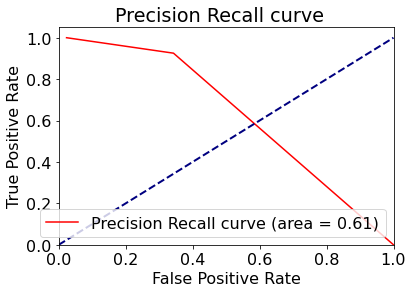

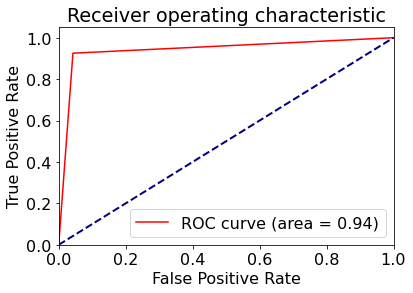

In [28]:
LR_model_pred_test_2, LR_model_prob_pred_test_2 = model_prediction(LR_best_model_2, X_test)
model_evaluaiton(y_test, LR_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     59000
           1       0.42      0.91      0.58      2000

    accuracy                           0.96     61000
   macro avg       0.71      0.93      0.78     61000
weighted avg       0.98      0.96      0.96     61000

[[56479  2521]
 [  175  1825]]
Accuracy: 0.9558032786885245
roc_auc_score: 0.934885593220339
precision_score: 0.4199263690750115
recall_score: 0.9125
f1_score: 0.575165458556571
CM: FP 2521
CM: FN 175
APS Cost =  112710


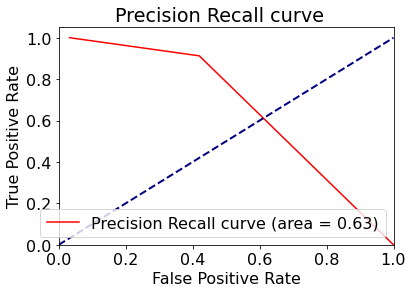

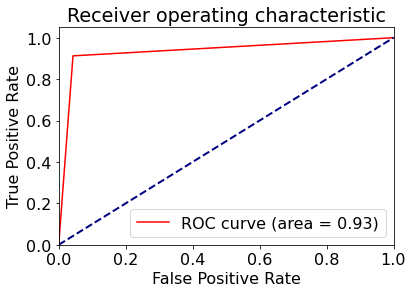

In [29]:
LR_model_pred_train_2, LR_model_prob_pred_train_2 = model_prediction(LR_best_model_2, X_train_2)
model_evaluaiton(y_train_2, LR_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [30]:
LR_best_th_2 = find_cut_off(y_test, LR_model_prob_pred_test_2[:,1])

100%|██████████| 12056/12056 [07:29<00:00, 26.83it/s]

Best threshold: 0.3251
Min cost: 16280.00


In [31]:
LR_best_th_2

0.32510209950989677

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.97      0.41       375

    accuracy                           0.94     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14597  1028]
 [   12   363]]
Accuracy: 0.935
roc_auc_score: 0.9511040000000001
precision_score: 0.2609633357296909
recall_score: 0.968
f1_score: 0.41109852774631933
CM: FP 1028
CM: FN 12
APS Cost =  16280


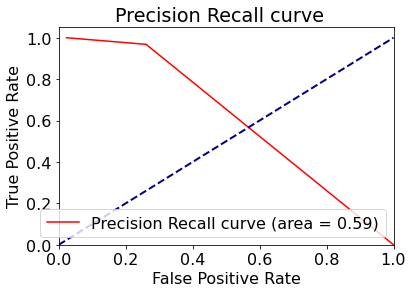

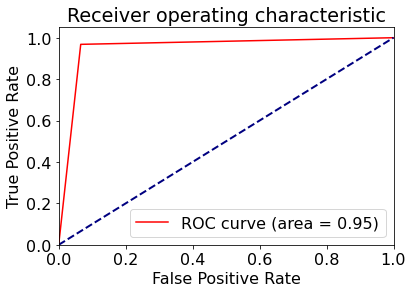

In [32]:
LR_predict_test_th_2 = LR_model_prob_pred_test_2[:,1] > LR_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [33]:
(1.0-LR_best_th_2)
lr_th_2 = round((1.0-LR_best_th_2),3)
lr_th_2

0.6748979004901032

0.675

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.97      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14596  1029]
 [   12   363]]
Accuracy: 0.9349375
roc_auc_score: 0.951072
precision_score: 0.2607758620689655
recall_score: 0.968
f1_score: 0.41086587436332767
CM: FP 1029
CM: FN 12
APS Cost =  16290


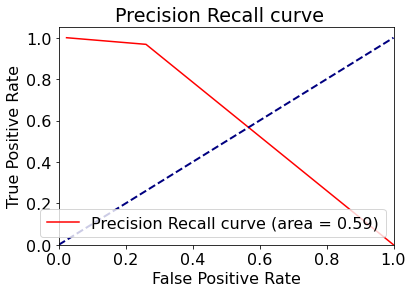

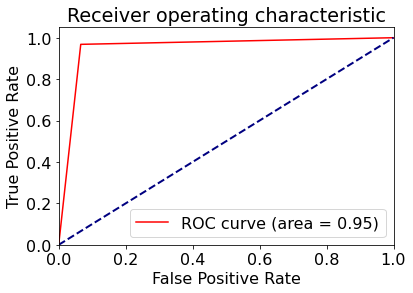

In [225]:
y_2 = LR_model_prob_pred_test_2[:,0] < lr_th_2
model_evaluaiton(y_test, y_2, "")

----

### Logistic Regression : df_train_5 (i.e. IR = 0.4)

In [35]:
X_train_5, y_train_5 = get_train_data(df_train_5)
LR_best_model_5 = lr_model(X_train_5, y_train_5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.34      0.92      0.49       375

    accuracy                           0.96     16000
   macro avg       0.67      0.94      0.74     16000
weighted avg       0.98      0.96      0.97     16000

[[14954   671]
 [   31   344]]
Accuracy: 0.956125
roc_auc_score: 0.9371946666666666
precision_score: 0.3389162561576355
recall_score: 0.9173333333333333
f1_score: 0.4949640287769784
CM: FP 671
CM: FN 31
APS Cost =  22210


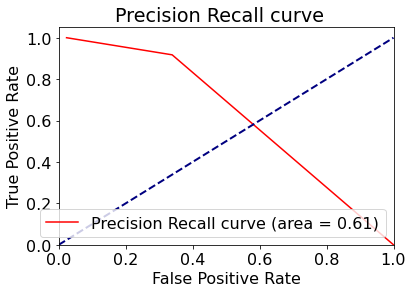

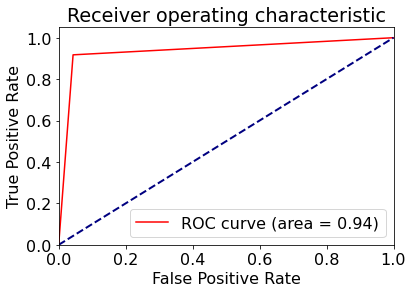

In [36]:
LR_model_pred_test_5, LR_model_prob_pred_test_5 = model_prediction(LR_best_model_5, X_test)
model_evaluaiton(y_test, LR_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     59000
           1       0.64      0.92      0.76      5000

    accuracy                           0.95     64000
   macro avg       0.82      0.94      0.87     64000
weighted avg       0.97      0.95      0.96     64000

[[56458  2542]
 [  412  4588]]
Accuracy: 0.95384375
roc_auc_score: 0.9372576271186441
precision_score: 0.6434782608695652
recall_score: 0.9176
f1_score: 0.7564715581203626
CM: FP 2542
CM: FN 412
APS Cost =  231420


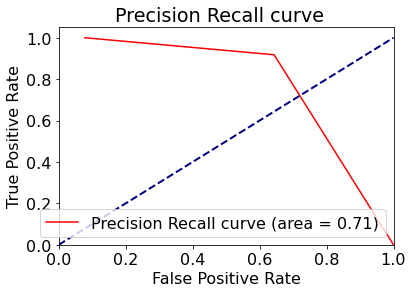

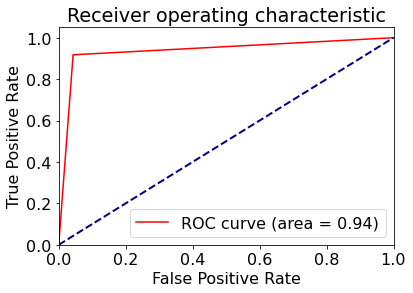

In [37]:
LR_model_pred_train_5, LR_model_prob_pred_train_5 = model_prediction(LR_best_model_5, X_train_5)
model_evaluaiton(y_train_5, LR_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [38]:
LR_best_th_5 = find_cut_off(y_test, LR_model_prob_pred_test_5[:,1])

100%|██████████| 14569/14569 [09:32<00:00, 25.47it/s]

Best threshold: 0.2896
Min cost: 16670.00


In [39]:
LR_best_th_5

0.28963842985162913

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.38       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14458  1167]
 [   10   365]]
Accuracy: 0.9264375
roc_auc_score: 0.9493226666666666
precision_score: 0.23825065274151436
recall_score: 0.9733333333333334
f1_score: 0.3828002097535396
CM: FP 1167
CM: FN 10
APS Cost =  16670


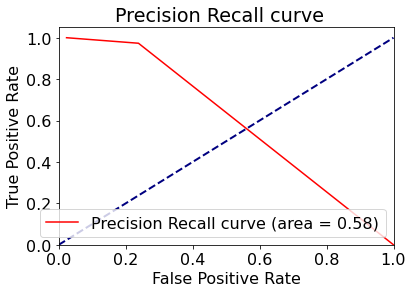

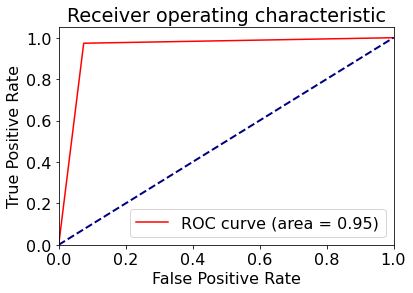

In [40]:
LR_predict_test_th_5 = LR_model_prob_pred_test_5[:,1] > LR_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [41]:
(1.0-LR_best_th_5)
lr_th_5 = round((1.0-LR_best_th_5),3)
lr_th_5

0.7103615701483709

0.71

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.38       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14458  1167]
 [   11   364]]
Accuracy: 0.926375
roc_auc_score: 0.9479893333333334
precision_score: 0.23775310254735468
recall_score: 0.9706666666666667
f1_score: 0.38195173137460653
CM: FP 1167
CM: FN 11
APS Cost =  17170


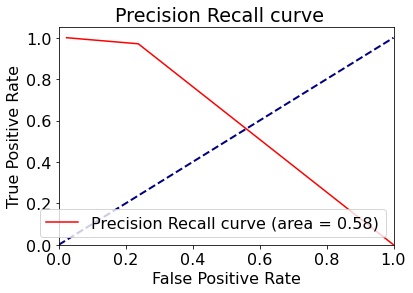

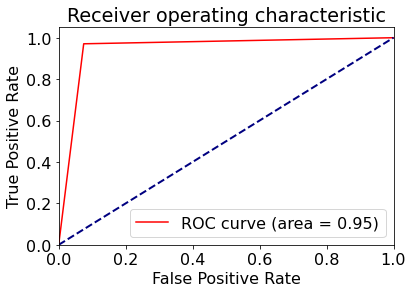

In [227]:
y_5 = LR_model_prob_pred_test_5[:,0] < lr_th_5
model_evaluaiton(y_test, y_5, "")

-----

### Logistic Regression : df_train_10 (i.e. IR = 0.6)

In [43]:
X_train_10, y_train_10 = get_train_data(df_train_10)
LR_best_model_10 = lr_model(X_train_10, y_train_10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.34      0.93      0.50       375

    accuracy                           0.96     16000
   macro avg       0.67      0.94      0.74     16000
weighted avg       0.98      0.96      0.97     16000

[[14943   682]
 [   27   348]]
Accuracy: 0.9556875
roc_auc_score: 0.942176
precision_score: 0.3378640776699029
recall_score: 0.928
f1_score: 0.49537366548042705
CM: FP 682
CM: FN 27
APS Cost =  20320


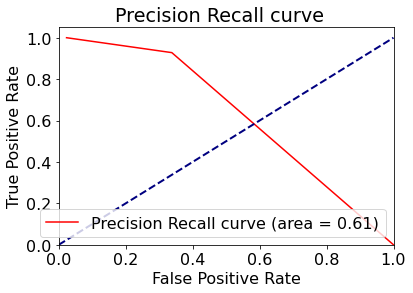

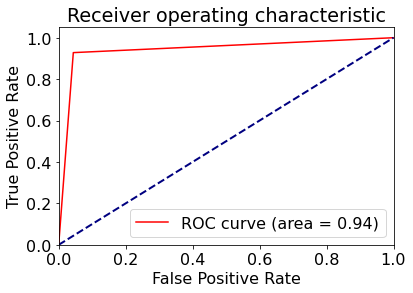

In [44]:
LR_model_pred_test_10, LR_model_prob_pred_test_10 = model_prediction(LR_best_model_10, X_test)
model_evaluaiton(y_test, LR_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     59000
           1       0.78      0.92      0.85     10000

    accuracy                           0.95     69000
   macro avg       0.88      0.94      0.91     69000
weighted avg       0.96      0.95      0.95     69000

[[56434  2566]
 [  804  9196]]
Accuracy: 0.9511594202898551
roc_auc_score: 0.9380542372881355
precision_score: 0.7818398231593267
recall_score: 0.9196
f1_score: 0.8451429096590387
CM: FP 2566
CM: FN 804
APS Cost =  427660


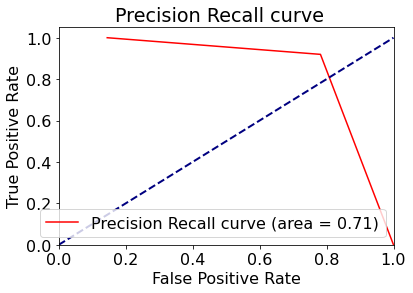

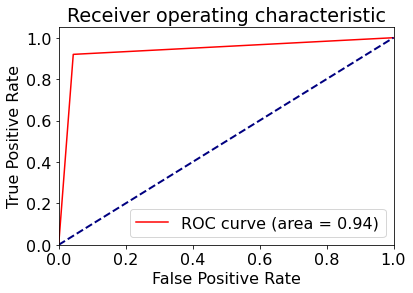

In [45]:
LR_model_pred_train_10, LR_model_prob_pred_train_10 = model_prediction(LR_best_model_10, X_train_10)
model_evaluaiton(y_train_10, LR_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [46]:
LR_best_th_10 = find_cut_off(y_test, LR_model_prob_pred_test_10[:,1])

100%|██████████| 14998/14998 [09:07<00:00, 27.39it/s]

Best threshold: 0.3714
Min cost: 16480.00


In [47]:
LR_best_th_10

0.37136727633644134

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.96      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.95      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14727   898]
 [   15   360]]
Accuracy: 0.9429375
roc_auc_score: 0.951264
precision_score: 0.2861685214626391
recall_score: 0.96
f1_score: 0.44090630740967546
CM: FP 898
CM: FN 15
APS Cost =  16480


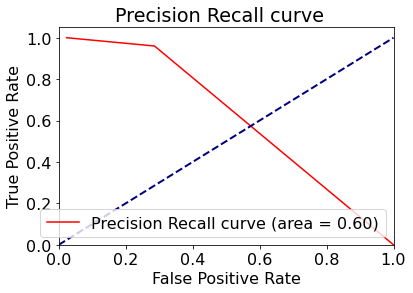

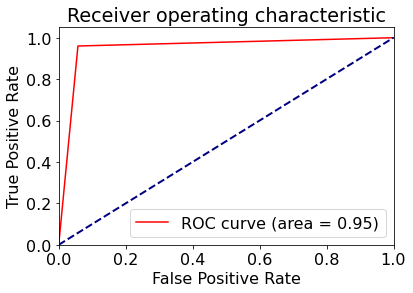

In [48]:
LR_predict_test_th_10 = LR_model_prob_pred_test_10[:,1] > LR_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [49]:
(1.0-LR_best_th_10)
lr_th_3 = round((1.0-LR_best_th_10),3)
lr_th_3

0.6286327236635587

0.629

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.96      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.95      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14726   899]
 [   15   360]]
Accuracy: 0.942875
roc_auc_score: 0.951232
precision_score: 0.28594122319301035
recall_score: 0.96
f1_score: 0.4406364749082008
CM: FP 899
CM: FN 15
APS Cost =  16490


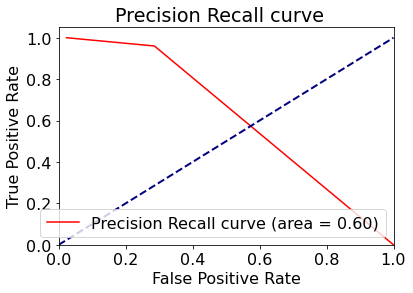

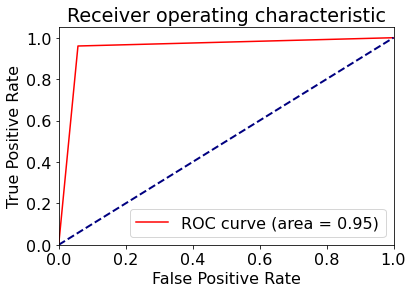

In [229]:
y_10 = LR_model_prob_pred_test_10[:,0] < lr_th_3
model_evaluaiton(y_test, y_10, "")

----

### Logistic Regression : df_train_18 (i.e. IR = 0.8)

In [51]:
X_train_18, y_train_18 = get_train_data(df_train_18)
LR_best_model_18 = lr_model(X_train_18, y_train_18)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.34      0.93      0.50       375

    accuracy                           0.96     16000
   macro avg       0.67      0.94      0.74     16000
weighted avg       0.98      0.96      0.97     16000

[[14955   670]
 [   28   347]]
Accuracy: 0.956375
roc_auc_score: 0.9412266666666667
precision_score: 0.34119960668633237
recall_score: 0.9253333333333333
f1_score: 0.49856321839080464
CM: FP 670
CM: FN 28
APS Cost =  20700


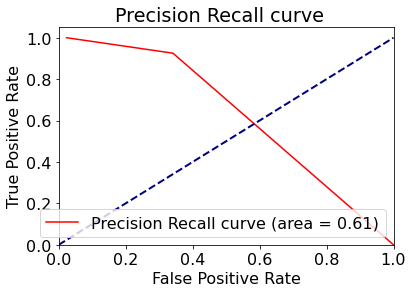

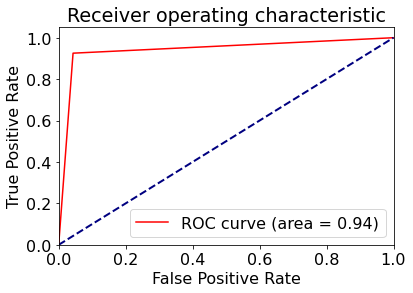

In [52]:
LR_model_pred_test_18, LR_model_prob_pred_test_18 = model_prediction(LR_best_model_18, X_test)
model_evaluaiton(y_test, LR_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     59000
           1       0.87      0.92      0.89     18000

    accuracy                           0.95     77000
   macro avg       0.92      0.94      0.93     77000
weighted avg       0.95      0.95      0.95     77000

[[56473  2527]
 [ 1448 16552]]
Accuracy: 0.9483766233766234
roc_auc_score: 0.9383625235404898
precision_score: 0.8675507102049373
recall_score: 0.9195555555555556
f1_score: 0.8927964616089971
CM: FP 2527
CM: FN 1448
APS Cost =  749270


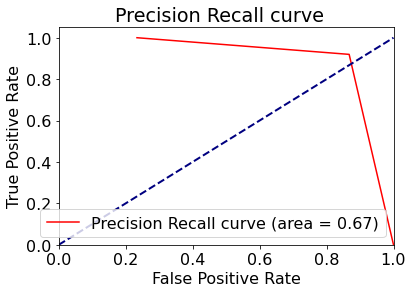

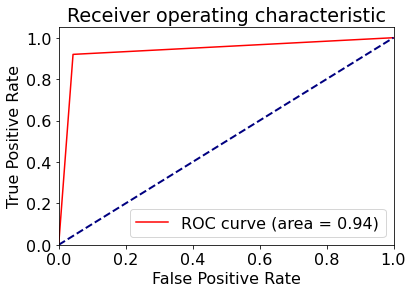

In [53]:
LR_model_pred_train_18, LR_model_prob_pred_train_18 = model_prediction(LR_best_model_18, X_train_18)
model_evaluaiton(y_train_18, LR_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_18[:, 1] : classifier probability's output for minority class

In [54]:
LR_best_th_18 = find_cut_off(y_test, LR_model_prob_pred_test_18[:,1])

100%|██████████| 11294/11294 [06:51<00:00, 27.42it/s]

Best threshold: 0.2894
Min cost: 16460.00


In [55]:
LR_best_th_18

0.2893857620093

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14479  1146]
 [   10   365]]
Accuracy: 0.92775
roc_auc_score: 0.9499946666666667
precision_score: 0.2415618795499669
recall_score: 0.9733333333333334
f1_score: 0.3870625662778367
CM: FP 1146
CM: FN 10
APS Cost =  16460


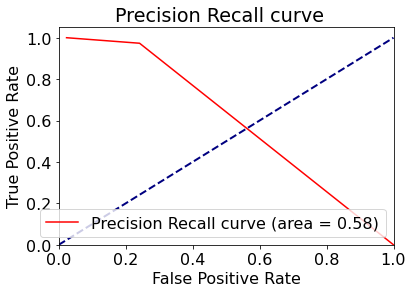

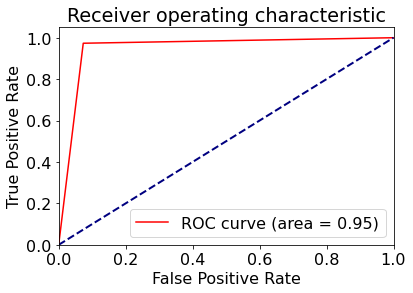

In [56]:
LR_predict_test_th_18 = LR_model_prob_pred_test_18[:,1] > LR_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [57]:
(1.0-LR_best_th_18)
lr_th_18 = round((1.0-LR_best_th_18),3)
lr_th_18

0.7106142379907

0.711

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14478  1147]
 [   10   365]]
Accuracy: 0.9276875
roc_auc_score: 0.9499626666666666
precision_score: 0.2414021164021164
recall_score: 0.9733333333333334
f1_score: 0.3868574456809751
CM: FP 1147
CM: FN 10
APS Cost =  16470


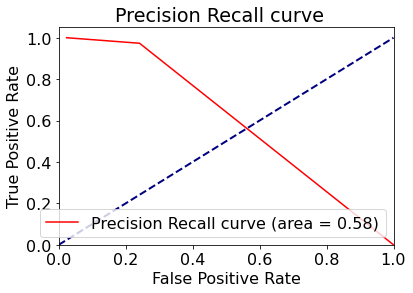

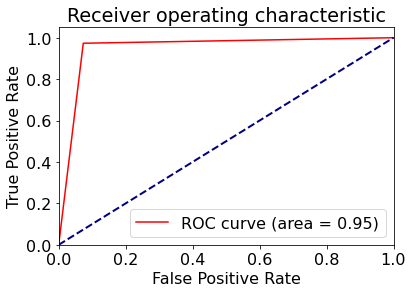

In [231]:
y_18 = LR_model_prob_pred_test_18[:,0] < lr_th_18
model_evaluaiton(y_test, y_18, "")

------

### Logistic Regression : df_train_59 (i.e. IR = 1.0)

In [59]:
X_train_59, y_train_59 = get_train_data(df_train_59)
LR_best_model_59 = lr_model(X_train_59, y_train_59)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.34      0.93      0.50       375

    accuracy                           0.96     16000
   macro avg       0.67      0.94      0.74     16000
weighted avg       0.98      0.96      0.97     16000

[[14946   679]
 [   28   347]]
Accuracy: 0.9558125
roc_auc_score: 0.9409386666666667
precision_score: 0.3382066276803119
recall_score: 0.9253333333333333
f1_score: 0.4953604568165596
CM: FP 679
CM: FN 28
APS Cost =  20790


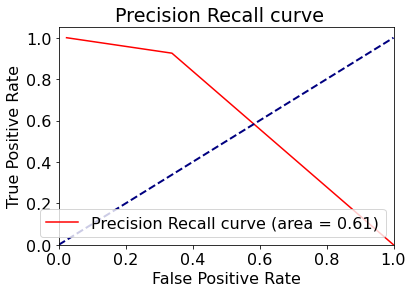

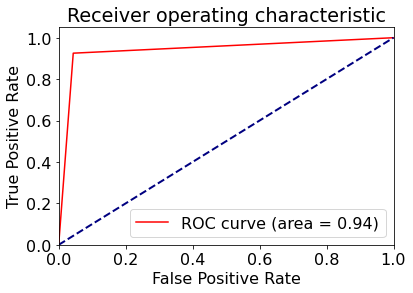

In [60]:
LR_model_pred_test_59, LR_model_prob_pred_test_59 = model_prediction(LR_best_model_59, X_test)
model_evaluaiton(y_test, LR_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     59000
           1       0.96      0.92      0.94     59000

    accuracy                           0.94    118000
   macro avg       0.94      0.94      0.94    118000
weighted avg       0.94      0.94      0.94    118000

[[56457  2543]
 [ 4811 54189]]
Accuracy: 0.937677966101695
roc_auc_score: 0.9376779661016948
precision_score: 0.9551752097581612
recall_score: 0.9184576271186441
f1_score: 0.9364566412055438
CM: FP 2543
CM: FN 4811
APS Cost =  2430930


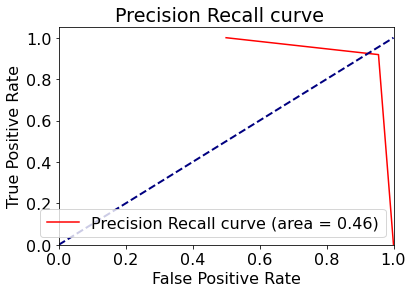

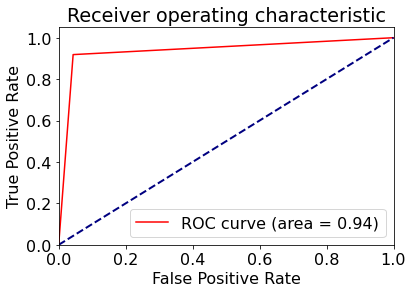

In [61]:
LR_model_pred_train_59, LR_model_prob_pred_train_59 = model_prediction(LR_best_model_59, X_train_59)
model_evaluaiton(y_train_59, LR_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [62]:
LR_best_th_59 = find_cut_off(y_test, LR_model_prob_pred_test_59[:,1])

100%|██████████| 14124/14124 [08:41<00:00, 27.10it/s]

Best threshold: 0.2792
Min cost: 16480.00


In [63]:
LR_best_th_59

0.2791666884348683

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.23      0.98      0.38       375

    accuracy                           0.92     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.92      0.95     16000

[[14427  1198]
 [    9   366]]
Accuracy: 0.9245625
roc_auc_score: 0.9496640000000001
precision_score: 0.2340153452685422
recall_score: 0.976
f1_score: 0.3775141825683342
CM: FP 1198
CM: FN 9
APS Cost =  16480


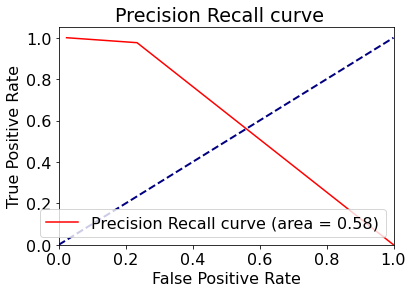

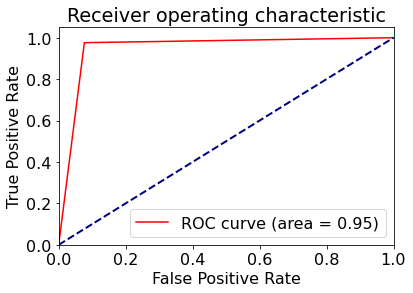

In [64]:
LR_predict_test_th_59 = LR_model_prob_pred_test_59[:,1] > LR_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [65]:
(1.0-LR_best_th_59)
lr_th_59 = round((1.0-LR_best_th_59),3)
lr_th_59

0.7208333115651318

0.721

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.23      0.98      0.38       375

    accuracy                           0.92     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.92      0.95     16000

[[14424  1201]
 [    9   366]]
Accuracy: 0.924375
roc_auc_score: 0.949568
precision_score: 0.23356732610082961
recall_score: 0.976
f1_score: 0.37693099897013393
CM: FP 1201
CM: FN 9
APS Cost =  16510


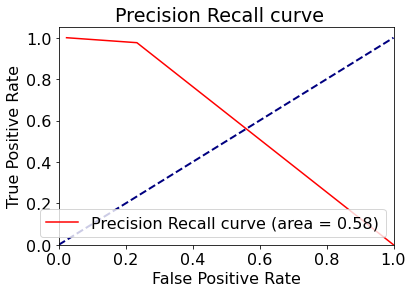

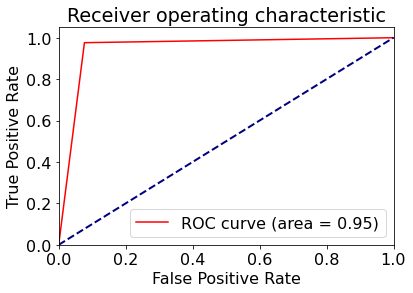

In [235]:
y_59 = LR_model_prob_pred_test_59[:,0] < lr_th_59
model_evaluaiton(y_test, y_59, "")

----

----

----

### Random Forest

In [119]:
def RF_model(X_train, y_train):
    # RF_hyperparameters = {
    #             'n_estimators': [50, 100, 250],
    #              'max_features': ['auto', 'sqrt', 'log2'],
    #             # 'max_depth': [5, 6, 8, None],
    #             'max_depth': [5, 6, 8],
    #             'criterion': ['gini', 'entropy']}

    ## Best Params based on running the previous range of hyperparameter
    RF_hyperparameters = {
                          'n_estimators': [250],
                           'max_depth': [5],
                          'criterion': ['entropy']}
    RF_clf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state= RANDOM_STATE),
                                   param_grid=RF_hyperparameters, cv=5,
                                   verbose=2, scoring=scoring_fn, n_jobs=-1)

    RF_best_model = RF_clf.fit(X_train, y_train)
    return RF_best_model

### df_train_2 (i.e. IR = 0.2)

In [120]:
X_train_2, y_train_2 = get_train_data(df_train_2)
RF_best_model_2 = RF_model(X_train_2, y_train_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   20.2s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.95      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.95      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14832   793]
 [   17   358]]
Accuracy: 0.949375
roc_auc_score: 0.9519573333333333
precision_score: 0.31

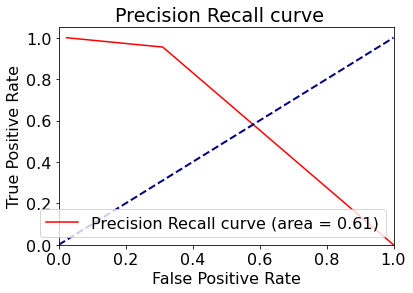

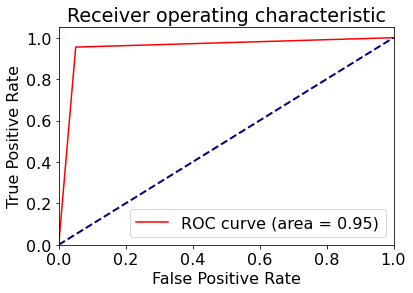

In [121]:
RF_model_pred_test_2, RF_model_prob_pred_test_2 = model_prediction(RF_best_model_2, X_test)
model_evaluaiton(y_test, RF_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     59000
           1       0.38      0.96      0.55      2000

    accuracy                           0.95     61000
   macro avg       0.69      0.95      0.76     61000
weighted avg       0.98      0.95      0.96     61000

[[55916  3084]
 [   80  1920]]
Accuracy: 0.9481311475409836
roc_auc_score: 0.953864406779661
precision_sc

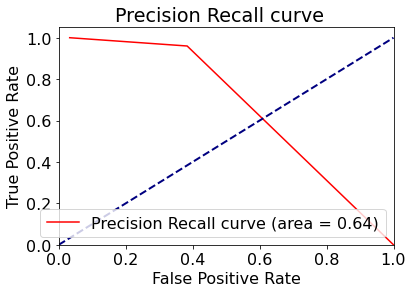

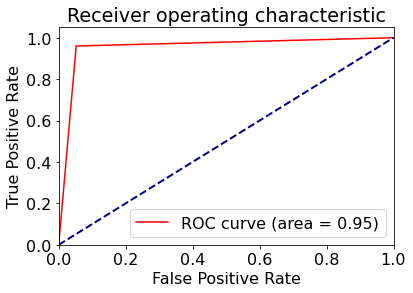

In [122]:
RF_model_pred_train_2, RF_model_prob_pred_train_2 = model_prediction(RF_best_model_2, X_train_2)
model_evaluaiton(y_train_2, RF_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [123]:
RF_best_th_2 = find_cut_off(y_test, RF_model_prob_pred_test_2[:,1])

100%|██████████| 8748/8748 [05:50<00:00, 24.98it/s]

Best threshold: 0.4001
Min cost: 13580.00


In [124]:
RF_best_th_2

0.400145700452146

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.43       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14667   958]
 [    8   367]]
Accuracy: 0.939625
roc_auc_score: 0.9586773333333334
precision_score: 0.2769811320754717
recall_score: 0.9786666666666667
f1_score: 0.43176470588235294
CM: FP 958
CM: FN 8
APS Cost =  13580


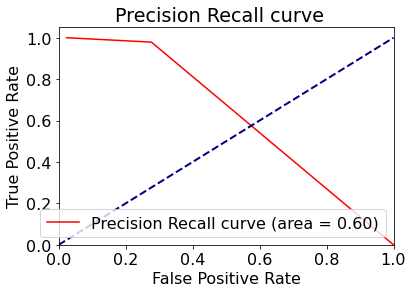

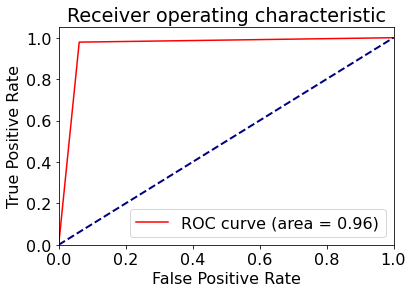

In [125]:
RF_predict_test_th_2 = RF_model_prob_pred_test_2[:,1] > RF_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [126]:
(1.0-RF_best_th_2)
rf_th_2 = round((1.0-RF_best_th_2),3)
rf_th_2

0.599854299547854

0.6

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.43       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14663   962]
 [    8   367]]
Accuracy: 0.939375
roc_auc_score: 0.9585493333333334
precision_score: 0.2761474793077502
recall_score: 0.9786666666666667
f1_score: 0.4307511737089202
CM: FP 962
CM: FN 8
APS Cost =  13620


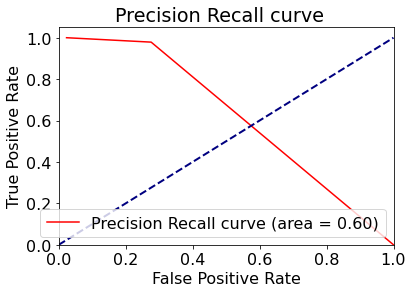

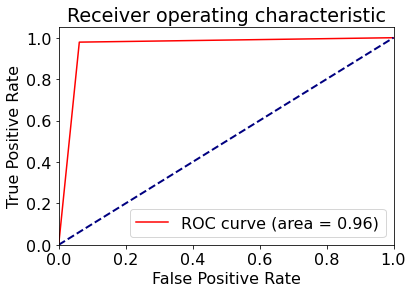

In [237]:
y_2 = RF_model_prob_pred_test_2[:,0] < rf_th_2
model_evaluaiton(y_test, y_2, "")

------

### df_train_5 (i.e. IR = 0.4)

In [128]:
X_train_5, y_train_5 = get_train_data(df_train_5)
RF_best_model_5 = RF_model(X_train_5, y_train_5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.9s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.96      0.46       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14805   820]
 [   14   361]]
Accuracy: 0.947875
roc_auc_score: 0.9550933333333333
precision_score: 0.30

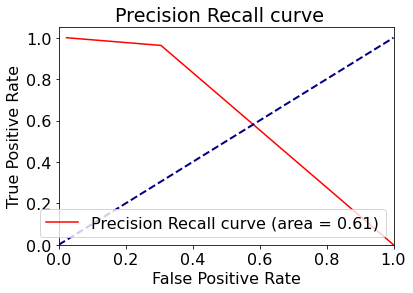

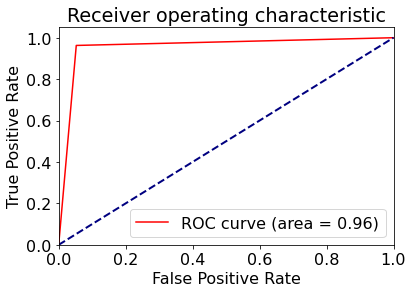

In [129]:
RF_model_pred_test_5, RF_model_prob_pred_test_5 = model_prediction(RF_best_model_5, X_test)
model_evaluaiton(y_test, RF_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     59000
           1       0.60      0.96      0.74      5000

    accuracy                           0.95     64000
   macro avg       0.80      0.95      0.85     64000
weighted avg       0.97      0.95      0.95     64000

[[55789  3211]
 [  205  4795]]
Accuracy: 0.946625
roc_auc_score: 0.9522881355932203
precision_score: 0.59

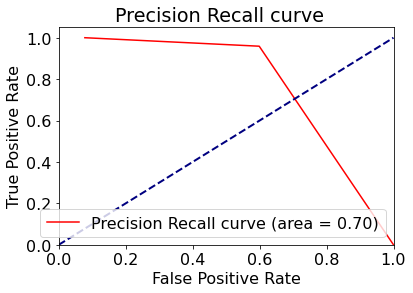

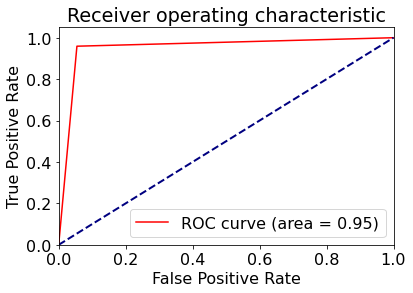

In [130]:
RF_model_pred_train_5, RF_model_prob_pred_train_5 = model_prediction(RF_best_model_5, X_train_5)
model_evaluaiton(y_train_5, RF_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [131]:
RF_best_th_5 = find_cut_off(y_test, RF_model_prob_pred_test_5[:,1])

100%|██████████| 9083/9083 [05:59<00:00, 25.25it/s]

Best threshold: 0.4044
Min cost: 13950.00


In [132]:
RF_best_th_5

0.404444406490676

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14630   995]
 [    8   367]]
Accuracy: 0.9373125
roc_auc_score: 0.9574933333333334
precision_score: 0.26945668135095446
recall_score: 0.9786666666666667
f1_score: 0.42256764536557284
CM: FP 995
CM: FN 8
APS Cost =  13950


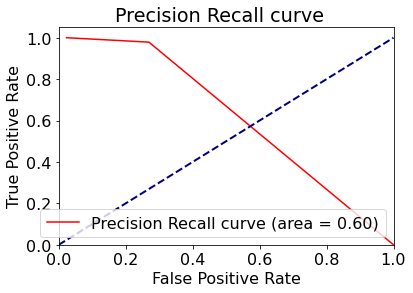

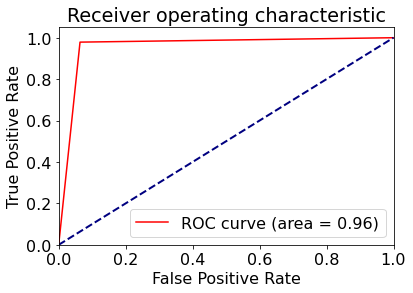

In [133]:
RF_predict_test_th_5 = RF_model_prob_pred_test_5[:,1] > RF_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [134]:
(1.0-RF_best_th_5)
rf_th_5 = round((1.0-RF_best_th_5),3)
rf_th_5

0.595555593509324

0.596

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14628   997]
 [    8   367]]
Accuracy: 0.9371875
roc_auc_score: 0.9574293333333335
precision_score: 0.2690615835777126
recall_score: 0.9786666666666667
f1_score: 0.4220816561242093
CM: FP 997
CM: FN 8
APS Cost =  13970


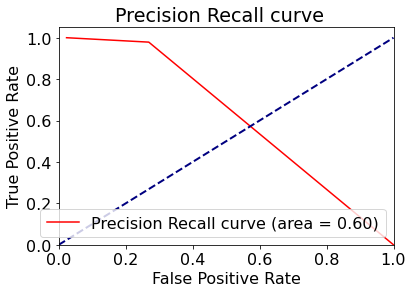

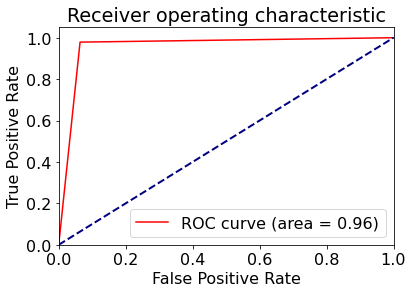

In [239]:
y_5 = RF_model_prob_pred_test_5[:,0] < rf_th_5
model_evaluaiton(y_test, y_5, "")

-----

### df_train_10 (i.e. IR = 0.6)

In [136]:
X_train_10, y_train_10 = get_train_data(df_train_10)
RF_best_model_10 = RF_model(X_train_10, y_train_10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.8s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.96      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14812   813]
 [   14   361]]
Accuracy: 0.9483125
roc_auc_score: 0.9553173333333335
precision_score: 0.3

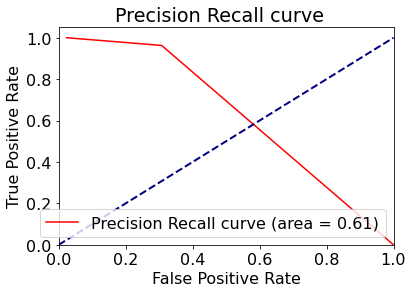

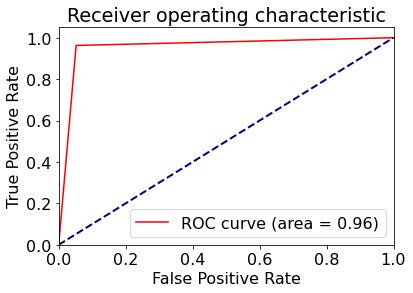

In [137]:
RF_model_pred_test_10, RF_model_prob_pred_test_10 = model_prediction(RF_best_model_10, X_test)
model_evaluaiton(y_test, RF_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     59000
           1       0.75      0.96      0.84     10000

    accuracy                           0.95     69000
   macro avg       0.87      0.95      0.91     69000
weighted avg       0.96      0.95      0.95     69000

[[55830  3170]
 [  418  9582]]
Accuracy: 0.948
roc_auc_score: 0.952235593220339
precision_score: 0.751411

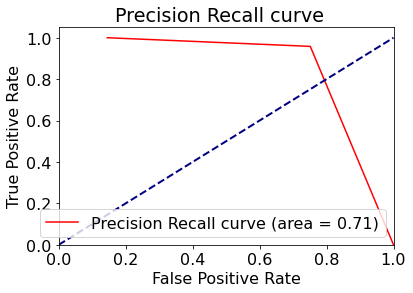

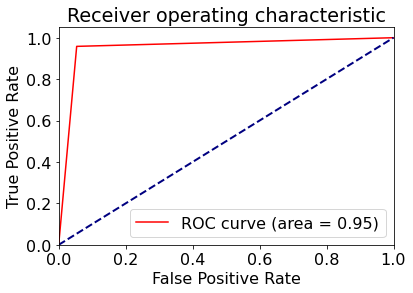

In [138]:
RF_model_pred_train_10, RF_model_prob_pred_train_10 = model_prediction(RF_best_model_10, X_train_10)
model_evaluaiton(y_train_10, RF_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [139]:
RF_best_th_10 = find_cut_off(y_test, RF_model_prob_pred_test_10[:,1])

100%|██████████| 9095/9095 [05:58<00:00, 25.37it/s]

Best threshold: 0.4563
Min cost: 13360.00


In [140]:
RF_best_th_10

0.4563191503775913

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.45       375

    accuracy                           0.94     16000
   macro avg       0.65      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14739   886]
 [    9   366]]
Accuracy: 0.9440625
roc_auc_score: 0.9596480000000001
precision_score: 0.29233226837060705
recall_score: 0.976
f1_score: 0.4499078057775046
CM: FP 886
CM: FN 9
APS Cost =  13360


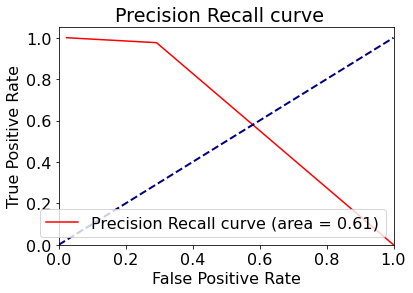

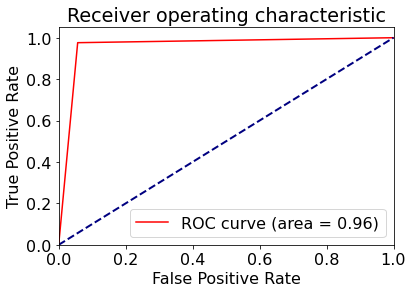

In [141]:
RF_predict_test_th_10 = RF_model_prob_pred_test_10[:,1] > RF_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [142]:
(1.0-RF_best_th_10)
rf_th_10 = round((1.0-RF_best_th_10),3)
rf_th_10

0.5436808496224087

0.544

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.45       375

    accuracy                           0.94     16000
   macro avg       0.65      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14738   887]
 [    9   366]]
Accuracy: 0.944
roc_auc_score: 0.959616
precision_score: 0.29209896249002393
recall_score: 0.976
f1_score: 0.4496314496314496
CM: FP 887
CM: FN 9
APS Cost =  13370


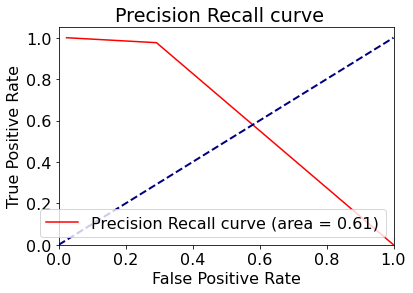

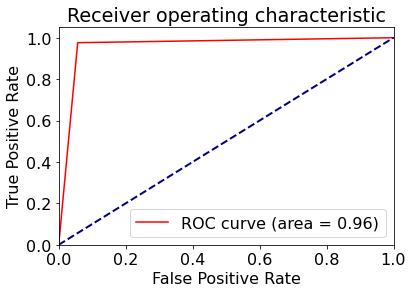

In [241]:
y_10 = RF_model_prob_pred_test_10[:,0] < rf_th_10
model_evaluaiton(y_test, y_10, "")

---

### df_train_18 (i.e. IR = 0.8)

In [144]:
X_train_18, y_train_18 = get_train_data(df_train_18)
RF_best_model_18 = RF_model(X_train_18, y_train_18)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   29.7s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.7s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.30      0.96      0.46       375

    accuracy                           0.95     16000
   macro avg       0.65      0.95      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14799   826]
 [   14   361]]
Accuracy: 0.9475
roc_auc_score: 0.9549013333333334
precision_score: 0.3041

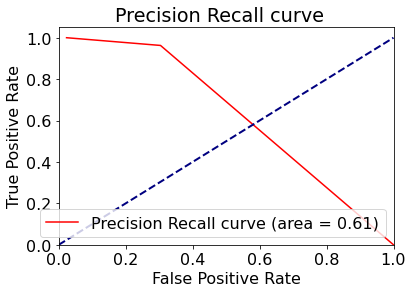

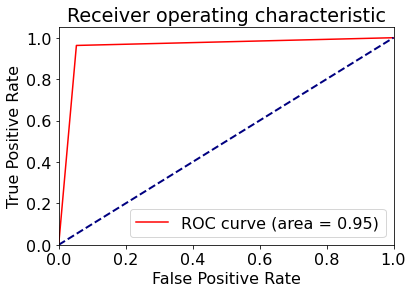

In [145]:
RF_model_pred_test_18, RF_model_prob_pred_test_18 = model_prediction(RF_best_model_18, X_test)
model_evaluaiton(y_test, RF_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     59000
           1       0.84      0.96      0.90     18000

    accuracy                           0.95     77000
   macro avg       0.91      0.95      0.93     77000
weighted avg       0.95      0.95      0.95     77000

[[55778  3222]
 [  752 17248]]
Accuracy: 0.9483896103896103
roc_auc_score: 0.9518060263653483
precision_s

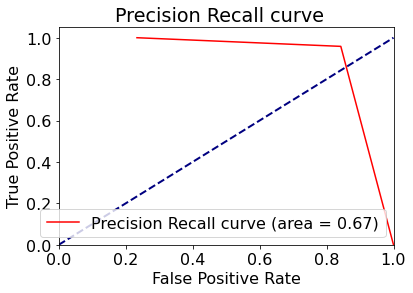

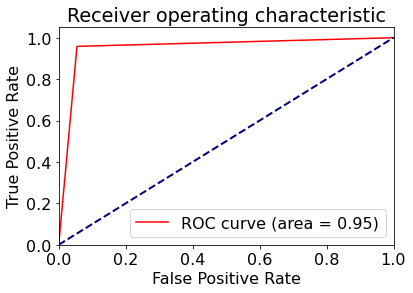

In [146]:
RF_model_pred_train_18, RF_model_prob_pred_train_18 = model_prediction(RF_best_model_18, X_train_18)
model_evaluaiton(y_train_18, RF_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_18[:,1] : classifier probability's output for minority class

In [147]:
RF_best_th_18 = find_cut_off(y_test, RF_model_prob_pred_test_18[:,1])

100%|██████████| 8205/8205 [05:19<00:00, 25.69it/s]

Best threshold: 0.4521
Min cost: 13570.00


In [148]:
RF_best_th_18

0.4520742753534962

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14718   907]
 [    9   366]]
Accuracy: 0.94275
roc_auc_score: 0.9589759999999999
precision_score: 0.2875098193244305
recall_score: 0.976
f1_score: 0.44417475728155337
CM: FP 907
CM: FN 9
APS Cost =  13570


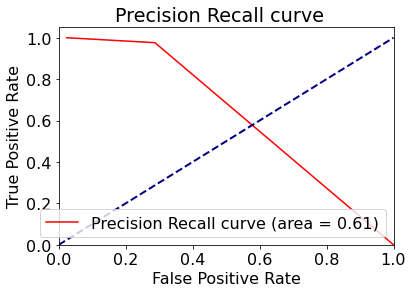

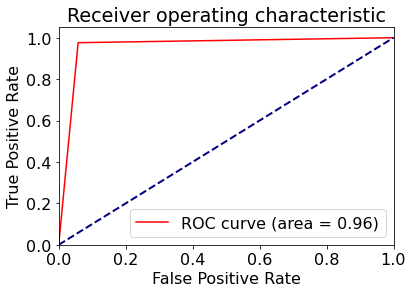

In [149]:
RF_predict_test_th_18 = RF_model_prob_pred_test_18[:,1] > RF_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [150]:
(1.0-RF_best_th_18)
rf_th_18 = round((1.0-RF_best_th_18),3)
rf_th_18

0.5479257246465038

0.548

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14716   909]
 [    9   366]]
Accuracy: 0.942625
roc_auc_score: 0.958912
precision_score: 0.28705882352941176
recall_score: 0.976
f1_score: 0.44363636363636366
CM: FP 909
CM: FN 9
APS Cost =  13590


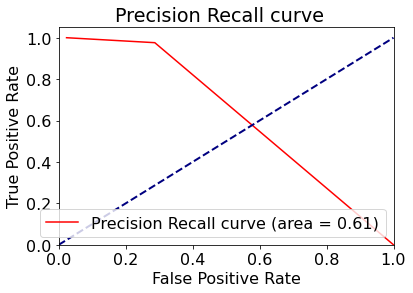

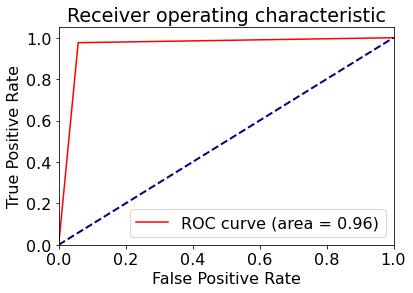

In [245]:
y_18 = RF_model_prob_pred_test_18[:,0] < rf_th_18
model_evaluaiton(y_test, y_18, "")

----

### df_train_59 (i.e. IR = 1.0)

In [152]:
X_train_59, y_train_59 = get_train_data(df_train_59)
RF_best_model_59 = RF_model(X_train_59, y_train_59)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   46.9s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.9s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.30      0.96      0.46       375

    accuracy                           0.95     16000
   macro avg       0.65      0.95      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14798   827]
 [   14   361]]
Accuracy: 0.9474375
roc_auc_score: 0.9548693333333335
precision_score: 0.3

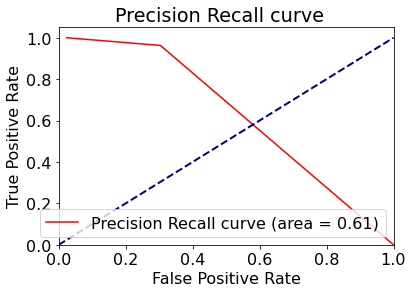

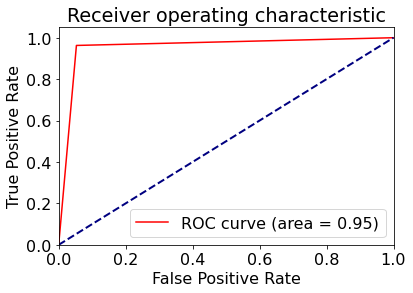

In [153]:
RF_model_pred_test_59, RF_model_prob_pred_test_59 = model_prediction(RF_best_model_59, X_test)
model_evaluaiton(y_test, RF_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     59000
           1       0.95      0.96      0.95     59000

    accuracy                           0.95    118000
   macro avg       0.95      0.95      0.95    118000
weighted avg       0.95      0.95      0.95    118000

[[55766  3234]
 [ 2548 56452]]
Accuracy: 0.951
roc_auc_score: 0.9510000000000001
precision_score: 0.94581

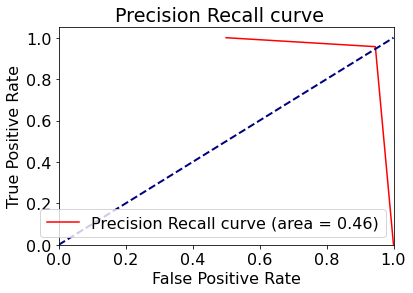

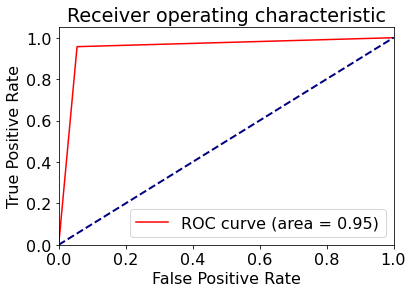

In [154]:
RF_model_pred_train_59, RF_model_prob_pred_train_59 = model_prediction(RF_best_model_59, X_train_59)
model_evaluaiton(y_train_59, RF_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [155]:
RF_best_th_59 = find_cut_off(y_test, RF_model_prob_pred_test_59[:,1])

100%|██████████| 8240/8240 [05:23<00:00, 25.45it/s]

Best threshold: 0.3362
Min cost: 13830.00


In [156]:
RF_best_th_59

0.3361852512401703

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.24      0.99      0.38       375

    accuracy                           0.93     16000
   macro avg       0.62      0.96      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14442  1183]
 [    4   371]]
Accuracy: 0.9258125
roc_auc_score: 0.9568106666666666
precision_score: 0.23873873873873874
recall_score: 0.9893333333333333
f1_score: 0.3846552617936755
CM: FP 1183
CM: FN 4
APS Cost =  13830


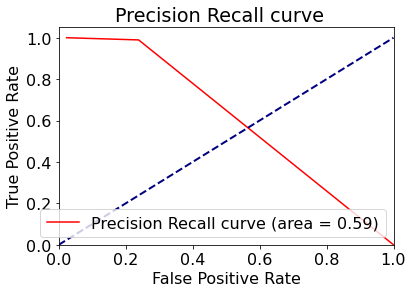

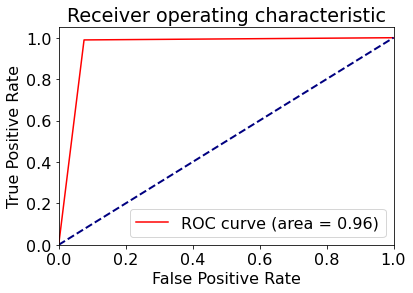

In [157]:
RF_predict_test_th_59 = RF_model_prob_pred_test_59[:,1] > RF_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [158]:
(1.0-RF_best_th_59)
rf_th_59 = round((1.0-RF_best_th_59),3)
rf_th_59

0.6638147487598297

0.664

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.24      0.99      0.38       375

    accuracy                           0.93     16000
   macro avg       0.62      0.96      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14441  1184]
 [    4   371]]
Accuracy: 0.92575
roc_auc_score: 0.9567786666666667
precision_score: 0.23858520900321542
recall_score: 0.9893333333333333
f1_score: 0.3844559585492228
CM: FP 1184
CM: FN 4
APS Cost =  13840


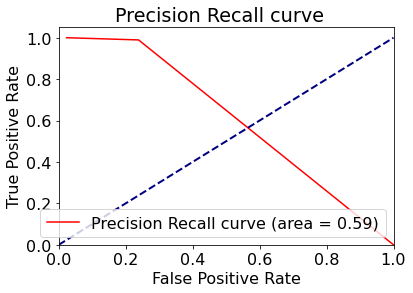

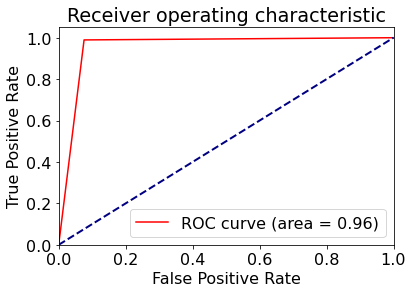

In [247]:
y_59 = RF_model_prob_pred_test_59[:,0] < rf_th_59
model_evaluaiton(y_test, y_59, "")

----

## XGBoost

In [160]:
def xgb_model(X_train, y_train):
    # xg_hyperparameters = {
    #                 'max_depth': [3, 4, 5],
    #                 'n_estimators': [50, 100],
    #                 'learning_rate': [0.1, 0.01, 0.05]
    #             }

    # best param when PCA is used
    xg_hyperparameters = {
                    'max_depth': [5],
                    'n_estimators': [100],
                    'learning_rate': [0.1]
                }
    xg_clf = GridSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE),
                                   param_grid=xg_hyperparameters, cv=5,
                                   scoring=scoring_fn, n_jobs=-1,verbose=2)
    
    xgbb_best_model = xg_clf.fit(X_train, y_train)
    return xgbb_best_model

### df_train_2 (i.e. IR = 0.2)

In [161]:
X_train_2, y_train_2 = get_train_data(df_train_2)
xgb_best_model_2 = xgb_model(X_train_2, y_train_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.9s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15625
           1       0.69      0.67      0.68       375

    accuracy                           0.99     16000
   macro avg       0.84      0.83      0.84     16000
weighted avg       0.98      0.99      0.99     16000

[[15511   114]
 [  124   251]]
Accuracy

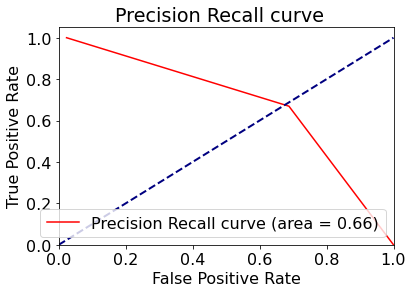

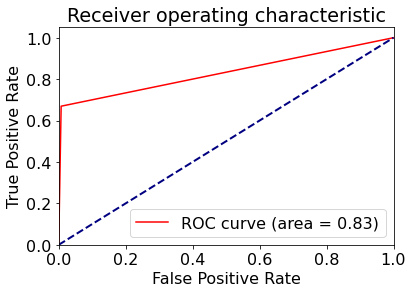

In [162]:
xgb_model_pred_test_2, xgb_model_prob_pred_test_2 = model_prediction(xgb_best_model_2, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     59000
           1       0.85      0.80      0.82      2000

    accuracy                           0.99     61000
   macro avg       0.92      0.90      0.91     61000
weighted avg       0.99      0.99      0.99     61000

[[58714   286]
 [  398  1602]]
Accuracy

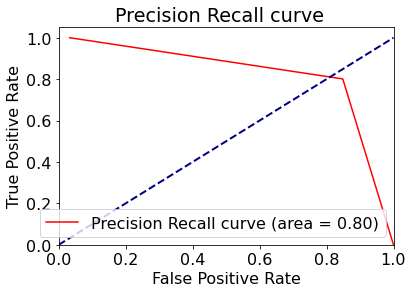

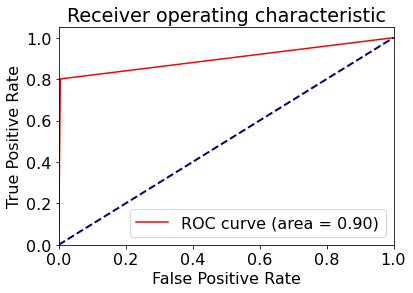

In [163]:
xgb_model_pred_train_2, xgb_model_prob_pred_train_2 = model_prediction(xgb_best_model_2, X_train_2)
model_evaluaiton(y_train_2, xgb_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [164]:
xgb_best_th_2 = find_cut_off(y_test, xgb_model_prob_pred_test_2[:,1])

100%|██████████| 6674/6674 [04:11<00:00, 26.53it/s]

Best threshold: 0.0260
Min cost: 13110.00


In [165]:
xgb_best_th_2

0.02602109

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14714   911]
 [    8   367]]
Accuracy: 0.9425625
roc_auc_score: 0.9601813333333333
precision_score: 0.2871674491392801
recall_score: 0.9786666666666667
f1_score: 0.44404113732607375
CM: FP 911
CM: FN 8
APS Cost =  13110


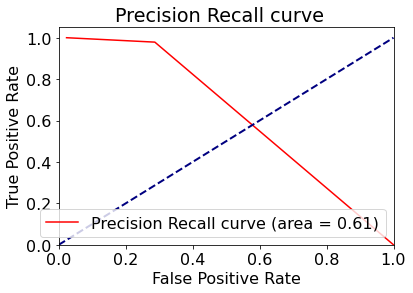

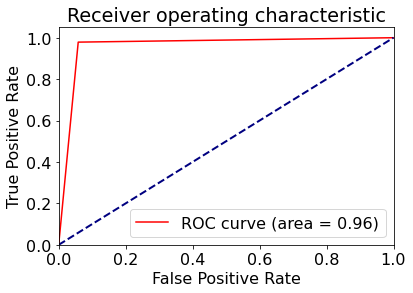

In [166]:
xgb_predict_test_th_2 = xgb_model_prob_pred_test_2[:,1] > xgb_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [167]:
(1.0-xgb_best_th_2)
xg_th_2 = round((1.0-xgb_best_th_2),3)
xg_th_2

0.9739789105951786

0.974

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.29      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.71     16000
weighted avg       0.98      0.94      0.96     16000

[[14711   914]
 [    8   367]]
Accuracy: 0.942375
roc_auc_score: 0.9600853333333333
precision_score: 0.2864949258391881
recall_score: 0.9786666666666667
f1_score: 0.44323671497584544
CM: FP 914
CM: FN 8
APS Cost =  13140


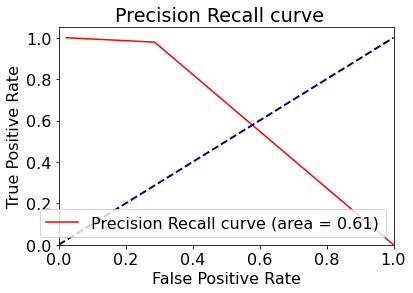

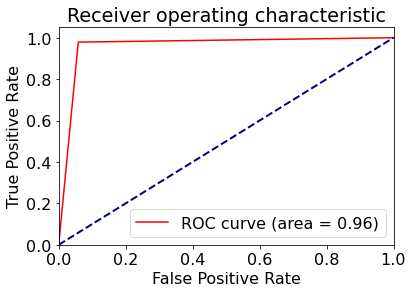

In [249]:
y_2 = xgb_model_prob_pred_test_2[:,0] < xg_th_2
model_evaluaiton(y_test, y_2, "")

-----

### df_train_5 (i.e. IR = 0.4)

In [169]:
X_train_5, y_train_5 = get_train_data(df_train_5)
xgb_best_model_5 = xgb_model(X_train_5, y_train_5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.2s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15625
           1       0.58      0.80      0.67       375

    accuracy                           0.98     16000
   macro avg       0.79      0.89      0.83     16000
weighted avg       0.99      0.98      0.98     16000

[[15408   217]
 [   74   301]]
Accuracy

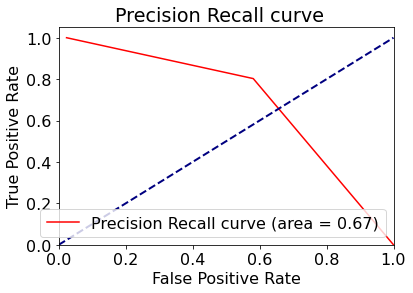

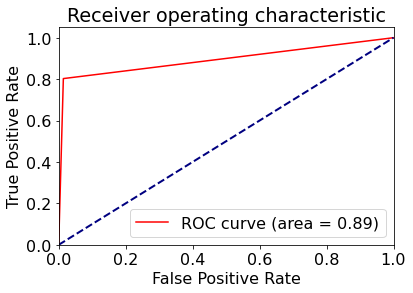

In [170]:
xgb_model_pred_test_5, xgb_model_prob_pred_test_5 = model_prediction(xgb_best_model_5, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59000
           1       0.86      0.91      0.88      5000

    accuracy                           0.98     64000
   macro avg       0.93      0.95      0.94     64000
weighted avg       0.98      0.98      0.98     64000

[[58274   726]
 [  462  4538]]
Accuracy

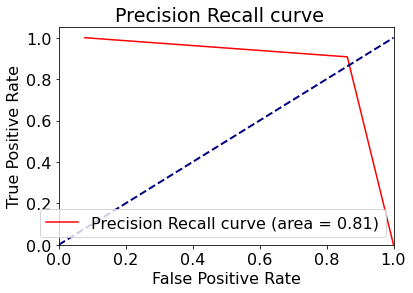

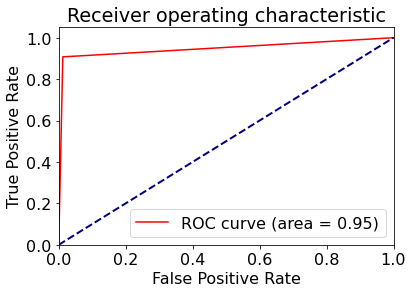

In [171]:
xgb_model_pred_train_5, xgb_model_prob_pred_train_5 = model_prediction(xgb_best_model_5, X_train_5)
model_evaluaiton(y_train_5, xgb_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [172]:
xgb_best_th_5 = find_cut_off(y_test, xgb_model_prob_pred_test_5[:,1])

100%|██████████| 6297/6297 [03:58<00:00, 26.41it/s]

Best threshold: 0.0767
Min cost: 13290.00


In [173]:
xgb_best_th_5

0.07670753

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.97      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14846   779]
 [   11   364]]
Accuracy: 0.950625
roc_auc_score: 0.9604053333333334
precision_score: 0.3184601924759405
recall_score: 0.9706666666666667
f1_score: 0.4795783926218708
CM: FP 779
CM: FN 11
APS Cost =  13290


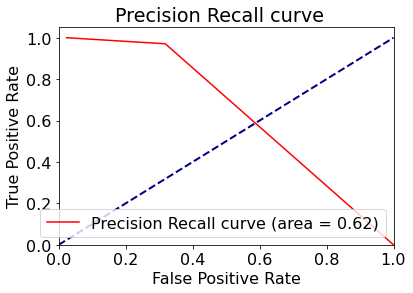

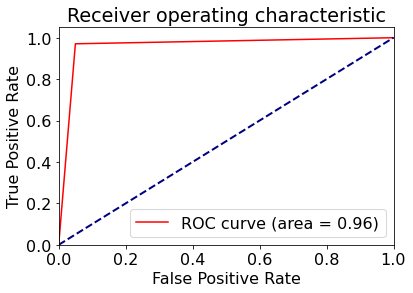

In [174]:
xgb_predict_test_th_5 = xgb_model_prob_pred_test_5[:,1] > xgb_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [175]:
(1.0-xgb_best_th_5)
xg_th_5 = round((1.0-xgb_best_th_5),3)
xg_th_5

0.9232924729585648

0.923

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.97      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14846   779]
 [   12   363]]
Accuracy: 0.9505625
roc_auc_score: 0.959072
precision_score: 0.3178633975481611
recall_score: 0.968
f1_score: 0.4785761371127225
CM: FP 779
CM: FN 12
APS Cost =  13790


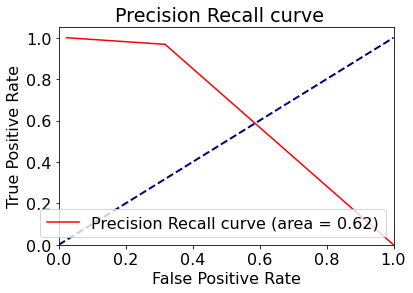

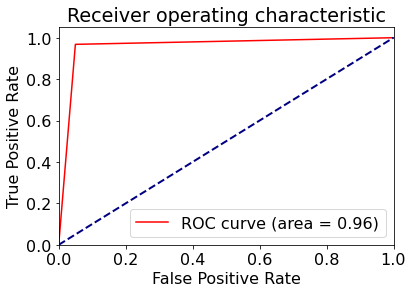

In [176]:
y_5 = xgb_model_prob_pred_test_5[:,0] < xg_th_5
model_evaluaiton(y_test, y_5, "")

----

### df_train_10 (i.e. IR = 0.6)

In [177]:
X_train_10, y_train_10 = get_train_data(df_train_10)
xgb_best_model_10 = xgb_model(X_train_10, y_train_10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.8s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.49      0.86      0.63       375

    accuracy                           0.98     16000
   macro avg       0.74      0.92      0.81     16000
weighted avg       0.98      0.98      0.98     16000

[[15290   335]
 [   51   324]]
Accuracy

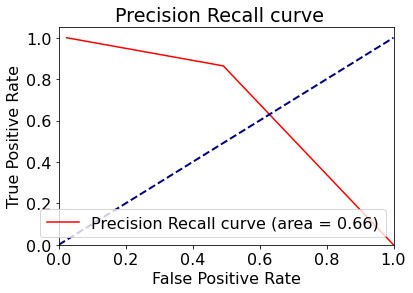

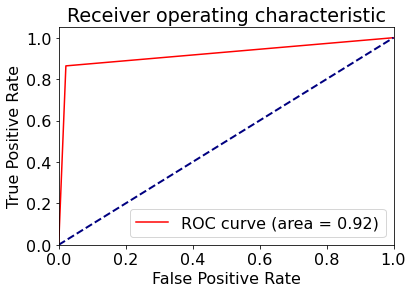

In [178]:
xgb_model_pred_test_10, xgb_model_prob_pred_test_10 = model_prediction(xgb_best_model_10, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     59000
           1       0.89      0.95      0.92     10000

    accuracy                           0.98     69000
   macro avg       0.94      0.96      0.95     69000
weighted avg       0.98      0.98      0.98     69000

[[57831  1169]
 [  522  9478]]
Accuracy

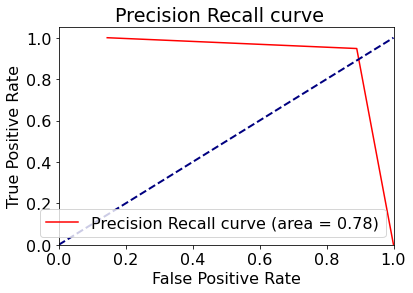

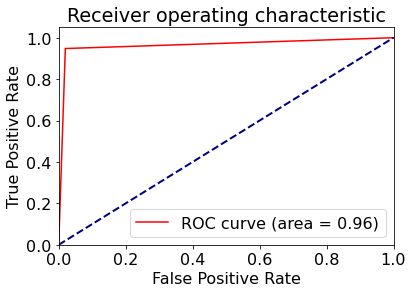

In [179]:
xgb_model_pred_train_10, xgb_model_prob_pred_train_10 = model_prediction(xgb_best_model_10, X_train_10)
model_evaluaiton(y_train_10, xgb_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [180]:
xgb_best_th_10 = find_cut_off(y_test, xgb_model_prob_pred_test_10[:,1])

100%|██████████| 6430/6430 [03:58<00:00, 26.94it/s]

Best threshold: 0.1172
Min cost: 12920.00


In [181]:
xgb_best_th_10

0.11715925

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.97      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14833   792]
 [   10   365]]
Accuracy: 0.949875
roc_auc_score: 0.9613226666666668
precision_score: 0.31547104580812446
recall_score: 0.9733333333333334
f1_score: 0.4765013054830287
CM: FP 792
CM: FN 10
APS Cost =  12920


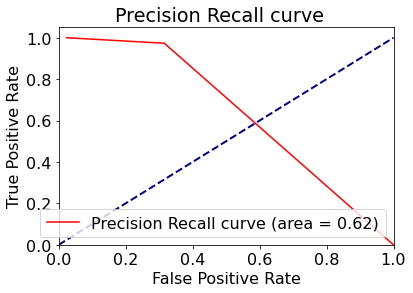

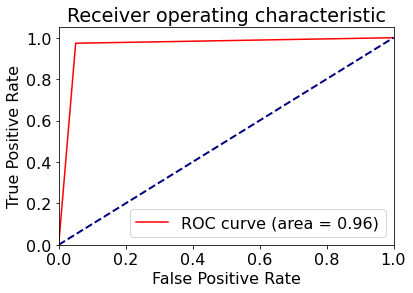

In [182]:
xgb_predict_test_th_10 = xgb_model_prob_pred_test_10[:,1] > xgb_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [183]:
(1.0-xgb_best_th_10)
xg_th_10 = round((1.0-xgb_best_th_10),3)
xg_th_10

0.8828407526016235

0.883

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.97      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14832   793]
 [   10   365]]
Accuracy: 0.9498125
roc_auc_score: 0.9612906666666666
precision_score: 0.31519861830742657
recall_score: 0.9733333333333334
f1_score: 0.47619047619047616
CM: FP 793
CM: FN 10
APS Cost =  12930


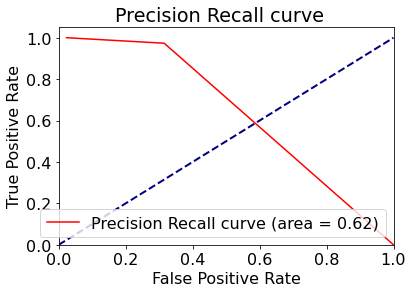

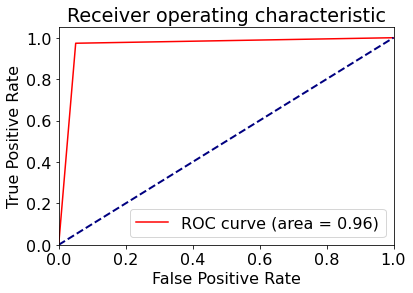

In [184]:
y_10 = xgb_model_prob_pred_test_10[:,0] < xg_th_10
model_evaluaiton(y_test, y_10, "")

-----

### df_train_18 (i.e. IR = 0.8)

In [185]:
X_train_18, y_train_18 = get_train_data(df_train_18)
xgb_best_model_18 = xgb_model(X_train_18, y_train_18)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.5s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.44      0.91      0.59       375

    accuracy                           0.97     16000
   macro avg       0.72      0.94      0.79     16000
weighted avg       0.98      0.97      0.98     16000

[[15197   428]
 [   35   340]]
Accuracy

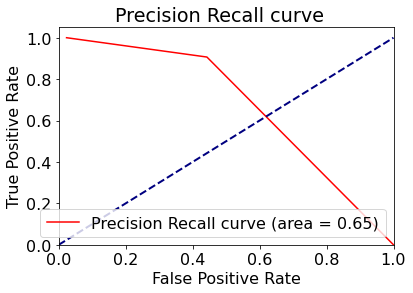

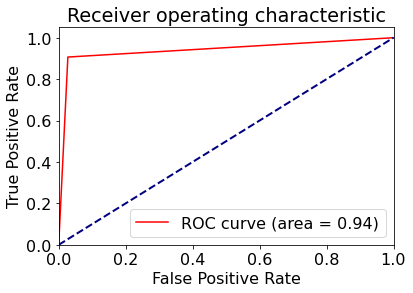

In [186]:
xgb_model_pred_test_18, xgb_model_prob_pred_test_18 = model_prediction(xgb_best_model_18, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     59000
           1       0.92      0.97      0.94     18000

    accuracy                           0.97     77000
   macro avg       0.96      0.97      0.96     77000
weighted avg       0.97      0.97      0.97     77000

[[57490  1510]
 [  552 17448]]
Accuracy

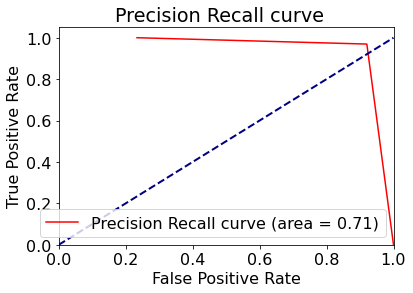

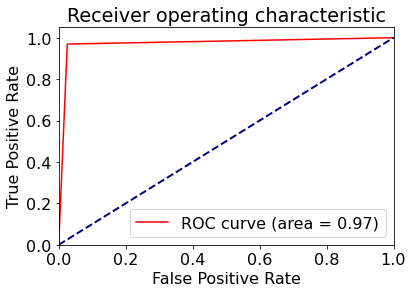

In [187]:
xgb_model_pred_train_18, xgb_model_prob_pred_train_18 = model_prediction(xgb_best_model_18, X_train_18)
model_evaluaiton(y_train_18, xgb_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_18[:,1] : classifier probability's output for minority class

In [188]:
xgb_best_th_18 = find_cut_off(y_test, xgb_model_prob_pred_test_18[:,1])

100%|██████████| 6076/6076 [03:42<00:00, 27.29it/s]

Best threshold: 0.1523
Min cost: 13190.00


In [189]:
xgb_best_th_18

0.15234546

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.97      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14806   819]
 [   10   365]]
Accuracy: 0.9481875
roc_auc_score: 0.9604586666666667
precision_score: 0.30827702702702703
recall_score: 0.9733333333333334
f1_score: 0.46824887748556765
CM: FP 819
CM: FN 10
APS Cost =  13190


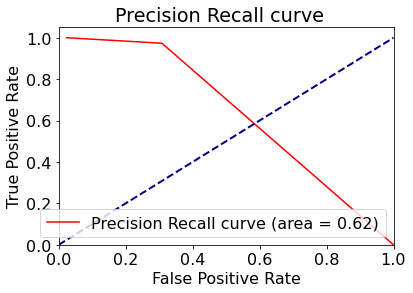

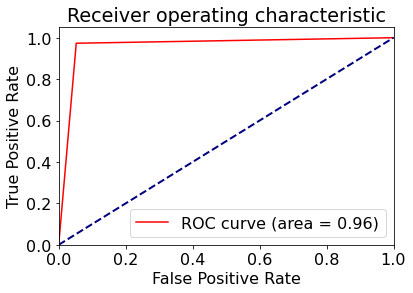

In [190]:
xgb_predict_test_th_18 = xgb_model_prob_pred_test_18[:,1] > xgb_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [191]:
(1.0-xgb_best_th_18)
xg_th_18 = round((1.0-xgb_best_th_18),3)
xg_th_18

0.8476545363664627

0.848

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.97      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14805   820]
 [   10   365]]
Accuracy: 0.948125
roc_auc_score: 0.9604266666666667
precision_score: 0.3080168776371308
recall_score: 0.9733333333333334
f1_score: 0.46794871794871795
CM: FP 820
CM: FN 10
APS Cost =  13200


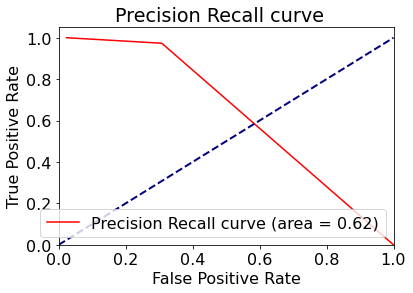

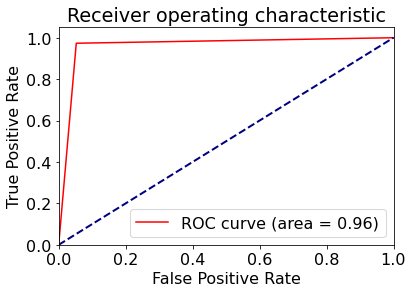

In [192]:
y_18 = xgb_model_prob_pred_test_18[:,0] < xg_th_18
model_evaluaiton(y_test, y_18, "")

-----

### df_train_59 (i.e. IR = 1.0)

In [193]:
X_train_59, y_train_59 = get_train_data(df_train_59)
xgb_best_model_59 = xgb_model(X_train_59, y_train_59)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.3s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.36      0.95      0.53       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14999   626]
 [   18   357]]
Accuracy

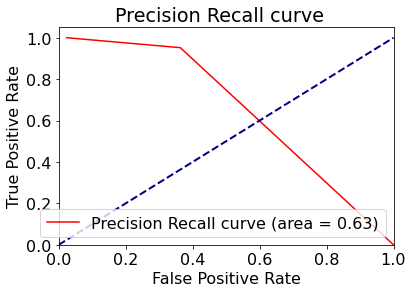

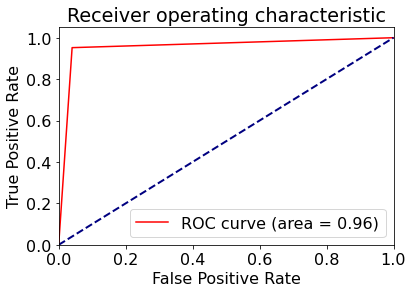

In [194]:
xgb_model_pred_test_59, xgb_model_prob_pred_test_59 = model_prediction(xgb_best_model_59, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     59000
           1       0.96      0.99      0.97     59000

    accuracy                           0.97    118000
   macro avg       0.97      0.97      0.97    118000
weighted avg       0.97      0.97      0.97    118000

[[56666  2334]
 [  872 58128]]
Accuracy

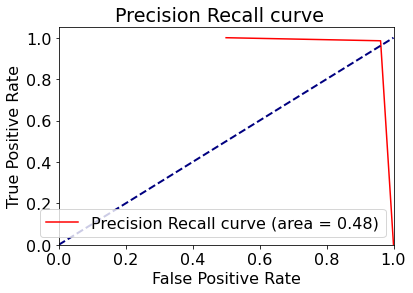

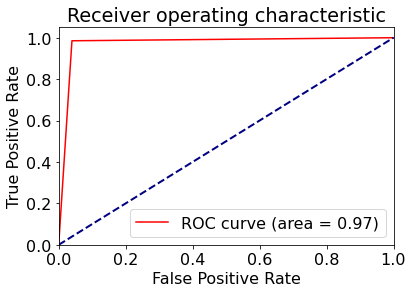

In [195]:
xgb_model_pred_train_59, xgb_model_prob_pred_train_59 = model_prediction(xgb_best_model_59, X_train_59)
model_evaluaiton(y_train_59, xgb_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [196]:
xgb_best_th_59 = find_cut_off(y_test, xgb_model_prob_pred_test_59[:,1])

100%|██████████| 6671/6671 [04:07<00:00, 26.95it/s]

Best threshold: 0.3838
Min cost: 15060.00


In [197]:
xgb_best_th_59

0.3838442

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.96      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14869   756]
 [   15   360]]
Accuracy: 0.9518125
roc_auc_score: 0.955808
precision_score: 0.3225806451612903
recall_score: 0.96
f1_score: 0.482897384305835
CM: FP 756
CM: FN 15
APS Cost =  15060


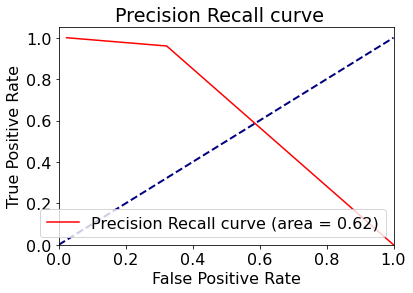

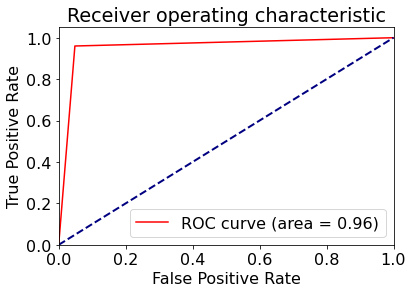

In [198]:
xgb_predict_test_th_59 = xgb_model_prob_pred_test_59[:,1] > xgb_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [199]:
(1.0-xgb_best_th_59)
xg_th_59 = round((1.0-xgb_best_th_59),3)
xg_th_59

0.6161558032035828

0.616

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.32      0.96      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.95      0.73     16000
weighted avg       0.98      0.95      0.96     16000

[[14869   756]
 [   16   359]]
Accuracy: 0.95175
roc_auc_score: 0.9544746666666668
precision_score: 0.3219730941704036
recall_score: 0.9573333333333334
f1_score: 0.48187919463087253
CM: FP 756
CM: FN 16
APS Cost =  15560


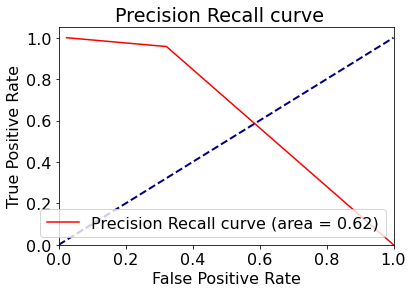

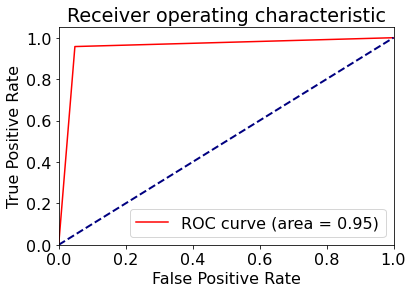

In [200]:
y_59 = xgb_model_prob_pred_test_59[:,0] < xg_th_59
model_evaluaiton(y_test, y_59, "")

----